# Imports

In [344]:
# %pip install kagglehub
# %pip install Unidecode
# %pip install rapidfuzz

In [345]:
import kagglehub
import re
import os
import ast
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, pairwise_distances, pairwise 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from unidecode import unidecode
from rapidfuzz import process, fuzz

Line below sets the displaying of df using pandas package to show all columns, and not to collapse them!

In [346]:
pd.set_option('display.max_columns', None)
%matplotlib inline

# Data collection, EDA & preproccessing

## Resorts

In [347]:
path = kagglehub.dataset_download("farheenshaukat/ski-resort")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Cyber_User\.cache\kagglehub\datasets\farheenshaukat\ski-resort\versions\1


In [348]:
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    data_file = os.path.join(path, csv_files[0]) # code in prev.cell downloads 2 datasets: resorts.csv and snow.csv, we need the first one 
    ski_df = pd.read_csv(data_file, encoding='latin1')
    print("Columns:", list(ski_df.columns))
else:
    print("No CSV file found in the dataset directory.")

ski_df.columns = ski_df.columns.str.strip() #  what for is this line? 
ski_df.describe()


Columns: ['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent', 'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes', 'Intermediate slopes', 'Difficult slopes', 'Total slopes', 'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts', 'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly', 'Snowparks', 'Nightskiing', 'Summer skiing']


,ID,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,250.000000,43.205684,-6.006784,48.721443,2160.589178,1200.631263,31.819639,37.921844,16.164329,85.905812,3.545090,179.136273,11.282565,9.721443,3.258517,24.262525,31650.961924
std,144.193157,15.975790,59.990459,21.718733,774.339805,596.142294,47.401764,44.358524,20.115855,100.874157,3.947887,372.321111,13.365360,11.461502,5.867967,27.672736,40781.986019
min,1.000000,-45.054960,-149.740657,0.000000,163.000000,36.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125.500000,43.672650,1.380975,36.000000,1594.000000,800.000000,10.000000,12.000000,3.000000,30.000000,0.000000,0.000000,3.000000,3.000000,0.000000,10.000000,11645.000000
50%,250.000000,46.347316,8.206372,45.000000,2175.000000,1121.000000,18.000000,25.000000,9.000000,55.000000,3.000000,15.000000,7.000000,6.000000,1.000000,15.000000,18510.000000
75%,374.500000,47.327089,12.429237,54.000000,2700.000000,1500.000000,30.000000,45.000000,21.000000,100.000000,6.000000,180.000000,14.000000,11.500000,4.000000,26.000000,32829.000000
max,499.000000,67.784406,176.876668,141.000000,3914.000000,3286.000000,312.000000,239.000000,126.000000,600.000000,16.000000,2383.000000,89.000000,74.000000,40.000000,174.000000,252280.000000


Mapping the categorical columns

Note: Season is slighlty problematic, we will map it to number of months a year the ski resort is opened

In [349]:
ski_df = ski_df.fillna(0)
non_numeric_cols = ski_df.select_dtypes(include=['object']).columns
ski_df[non_numeric_cols]

,Resort,Country,Continent,Season,Child friendly,Snowparks,Nightskiing,Summer skiing
0,Hemsedal,Norway,Europe,November - May,Yes,Yes,Yes,No
1,Geilosiden Geilo,Norway,Europe,November - April,Yes,Yes,Yes,No
2,Golm,Austria,Europe,December - April,Yes,No,No,No
3,Red Mountain Resort-Rossland,Canada,North America,December - April,Yes,Yes,Yes,No
4,Hafjell,Norway,Europe,November - April,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...
494,Puigmal,France,Europe,Unknown,Yes,No,No,No
495,Kranzberg-Mittenwald,Germany,Europe,December,Yes,Yes,Yes,No
496,Wetterstein lifts-Wettersteinbahnen- Ehrwald,Austria,Europe,December - March,Yes,Yes,No,No
497,Stuhleck-Spital am Semmering,Austria,Europe,April,Yes,Yes,Yes,No


In [350]:
ski_df["Season"].unique()

array(['November - May', 'November - April', 'December - April',
       'June - September', 'June - October', 'Year-round',
       'October - June', 'September - June', 'December - March',
       'October - May',
       'December - April, June - August, October - November',
       'July - September', 'November - May, June - August',
       'May - September', 'December - May', 'July', 'September - May',
       'October - April', 'April', 'Unknown', 'July - April',
       'May - October', 'November - June', 'September - April', 'May',
       'June - May', 'November - March', 'March', 'December',
       'October - November, December - May, June - October',
       'July - October'], dtype=object)

In [351]:
month_to_num = {month: i for i, month in enumerate(calendar.month_name) if month} # creates {"Jan": 1, ...} pairs for mapping 
num_to_month = {v: k for k, v in month_to_num.items()} # reverse 

def count_open_months(season_str): # function for apply method
    season_str = season_str.strip()
    if season_str.lower() == 'Unknown' or not season_str: # there's few
        return 0
    months_open = set()
    ranges = [s.strip() for s in season_str.split(',')]
    
    for r in ranges:
        if '-' in r:
            start, end = [s.strip() for s in r.split('-')]
            start_num = month_to_num.get(start)
            end_num = month_to_num.get(end)
            if start_num and end_num:
                if start_num <= end_num:
                    months = list(range(start_num, end_num + 1))
                else:  
                    months = list(range(start_num, 13)) + list(range(1, end_num + 1))
                months_open.update(months)
        else:  # single month like "December"
            single = r.strip()
            num = month_to_num.get(single)
            if num:
                months_open.add(num)
    return len(months_open)

In [352]:
non_numeric_cols = ['Country', 'Continent']
for col in non_numeric_cols:
    ski_df[col + "_numeric"], uniques = pd.factorize(ski_df[col])
for col in ['Child friendly', 'Snowparks', 'Nightskiing', 'Summer skiing']:
    ski_df[col + "_numeric"] = ski_df[col].map({"No" : 0, "Yes" : 1})
ski_df["Season_numeric"] = ski_df["Season"].apply(count_open_months)
ski_df.tail()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric
494,495,Puigmal,42.395007,2.108883,France,Europe,0,Unknown,2700,1830,9,15,7,31,0,0,11,2,0,13,11865,Yes,No,No,No,8,0,1,0,0,0,0
495,496,Kranzberg-Mittenwald,47.451359,11.228630,Germany,Europe,29,December,1350,980,6,7,2,15,2,8,9,1,0,10,5850,Yes,Yes,Yes,No,5,0,1,1,1,0,1
496,497,Wetterstein lifts-Wettersteinbahnen- Ehrwald,47.406897,10.927998,Austria,Europe,43,December - March,1530,1000,15,5,3,23,3,33,6,4,0,10,5425,Yes,Yes,No,No,1,0,1,1,0,0,4
497,498,Stuhleck-Spital am Semmering,47.574195,15.789964,Austria,Europe,42,April,1774,777,18,6,0,24,0,240,7,2,0,9,14400,Yes,Yes,Yes,No,1,0,1,1,1,0,1
498,499,Le Massif,47.275900,-70.625986,Canada,North America,51,December - April,806,36,12,16,11,39,3,716,2,3,2,7,11759,Yes,Yes,No,No,2,1,1,1,0,0,5


In [353]:
print(ski_df.columns)
print(ski_df.iloc[0])  

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric'],
      dtype='object')
ID                                     1
Resort                          Hemsedal
Latitude                       60.928244
Longitude                       8.383487
Country                           Norway
Continent                         Europe
Price                                 46
Season                    November - May
Highest point                       1450
Lowest point                 

## Adding cost of living

In [360]:
costs_df = pd.read_csv("data\Cost_of_Living_Index_by_Country_2024.csv")
costs_df

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Cyber_User\AppData\Local\Temp\ipykernel_18116\3972643006.py:1: SyntaxWarning: invalid escape sequence '\C'
  costs_df = pd.read_csv("data\Cost_of_Living_Index_by_Country_2024.csv")


,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,Switzerland,101.1,46.5,74.9,109.1,97.0,158.7
1,2,Bahamas,85.0,36.7,61.8,81.6,83.3,54.6
2,3,Iceland,83.0,39.2,62.0,88.4,86.8,120.3
3,4,Singapore,76.7,67.2,72.1,74.6,50.4,111.1
4,5,Barbados,76.6,19.0,48.9,80.8,69.4,43.5
...,...,...,...,...,...,...,...,...
116,117,Bangladesh,22.5,2.4,12.8,25.7,12.8,33.1
117,118,India,21.2,5.6,13.7,23.8,15.1,82.6
118,119,Egypt,21.0,3.7,12.7,21.2,16.2,20.0
119,120,Libya,20.4,4.3,12.7,22.2,15.2,42.0


In [361]:
mapping = dict(zip(costs_df["Country"], costs_df["Cost of Living Index"]))

ski_df["expense_score"] = ski_df["Country"].map(mapping)

## Rank Ski DF (for rank or ELO rating)

In [273]:
rank_path = 'data\\ski-resorts_ranks.csv'
rank_df = pd.read_csv(rank_path)
# Split 'location_coordinate' into 'location_lat' and 'location_long'
def extract_lat(coord):
    d = ast.literal_eval(coord)
    return float(d.get('lat', None)) 

def extract_log(coord):
        d = ast.literal_eval(coord)
        return float(d.get('long', None))

rank_df['location_lat'] = rank_df['location_coordinate'].apply(extract_lat)
rank_df['location_long'] = rank_df['location_coordinate'].apply(extract_log)

# Ensure numeric dtype (coordinates may be strings in the CSV)
rank_df['location_lat'] = pd.to_numeric(rank_df['location_lat'], errors='coerce')
rank_df['location_long'] = pd.to_numeric(rank_df['location_long'], errors='coerce')

rank_df.columns

Index(['rank', 'name', 'rating', 'url', 'location_coordinate',
       'location_country', 'location_region', 'elevation_top_m',
       'elevation_difference_m', 'total_slope_length_km', 'number_of_lifts',
       'number_of_slopes', 'annual_snowfall_cm', 'number_of_matches',
       'location_lat', 'location_long'],
      dtype='object')

In [274]:
rank_df.iloc[0]

rank                                                         1
name                                       4 Vallées (Verbier)
rating                                                  1311.7
url                                     http://www.4vallees.ch
location_coordinate       {'lat': '46.1013', 'long': '7.2263'}
location_country                                   Switzerland
location_region                                         Valais
elevation_top_m                                         3330.0
elevation_difference_m                                  1980.0
total_slope_length_km                                    412.0
number_of_lifts                                           68.0
number_of_slopes                                         307.0
annual_snowfall_cm                                       500.0
number_of_matches                                           65
location_lat                                           46.1013
location_long                                          

## Resort name matching


In [275]:
ski_df.Country.unique()

array(['Norway', 'Austria', 'Canada', 'New Zealand', 'Chile', 'Germany',
       'Switzerland', 'Italy', 'France', 'United Kingdom',
       'United States', 'Andorra', 'Australia', 'Argentina', 'Finland',
       'Japan', 'Slovenia', 'Bulgaria', 'Spain', 'Sweden', 'Lebanon',
       'Russia', 'Ukraine', 'Georgia', 'Serbia', 'Turkey', 'Slovakia',
       'Poland', 'Bosnia and Herzegovina', 'Czech Republic', 'Iran',
       'South Korea', 'Romania', 'Greece', 'Liechtenstein', 'Lithuania',
       'Kazakhstan', 'China'], dtype=object)

In [276]:
rank_df.location_country.unique()

array(['Switzerland', 'France', 'Austria', 'USA', 'Canada', 'Japan',
       'Italy', 'Andorra', 'Spain', 'Norway', 'Germany', 'Sweden',
       'Finland'], dtype=object)

In [277]:
ski_df.loc[ski_df['Country'] == 'United States', 'Country'] = 'USA'

In [278]:
# Matching algorithm 1 (hybrid: global high-score or same-country with tiered thresholds)
STOPWORDS = {
    "ski", "resort", "area", "mountain", "mt", "snow",
    "center", "centre", "valley", "park", "domain", "zone"
}

def normalise(name: str) -> str:
    """
    Lower-case, remove accents & punctuation, drop generic words,
    collapse whitespace.  Returns a canonical form suitable for matching.
    """
    n = unidecode(name)
    n = n.lower()
    n = re.sub(r"[()\-_/]", " ", n)
    tokens = re.split(r"\W+", n)
    keep = [t for t in tokens if t and t not in STOPWORDS]
    return " ".join(keep)

# Build keys for fuzzy matching
ski_df["key"]  = ski_df["Resort"].astype(str).map(normalise)
rank_df["key"] = rank_df["name"].astype(str).map(normalise)

# Candidate list over all rank entries (global search)
available_keys = rank_df['key'].dropna().tolist()
used_keys = set()  # Track already-matched keys to prevent duplicates

# Thresholds per requirement (strictly greater than)
STRICT_ACCEPT = 90   # >90: accept globally, ignore country
MISSING_COUNTRY_ACCEPT = 80  # >80: if either country missing
SAME_COUNTRY_ACCEPT = 49     # >49: if both countries present and equal

best_ranks = []
best_names = []
best_ratings = []
for _, row in ski_df.iterrows():
    key = row.get("key")
    ski_country = row.get("Country")

    # Only consider unused candidates (without replacement matching)
    current_candidates = [k for k in available_keys if k not in used_keys]
    
    if not current_candidates:
        # No more candidates available
        best_ranks.append(None)
        best_names.append(None)
        continue

    # Get top candidates globally by score from available candidates
    cands = process.extract(key, current_candidates, scorer=fuzz.token_set_ratio, limit=10)
    chosen_rank = None
    chosen_name = None
    chosen_rating = None
    chosen_key = None

    for cand_key, score, _ in cands:
        if cand_key in used_keys:
            continue
            
        # Fetch candidate row
        rdf = rank_df.loc[rank_df['key'] == cand_key]
        if rdf.empty:
            continue
        r = rdf.iloc[0]
        rank_country = r.get('location_country')

        # Rule 1: score > 90 => accept regardless of country
        if score > STRICT_ACCEPT:
            chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
            break

        # Rule 2: score <= 90 => apply country-aware thresholds
        # If either country is missing
        if pd.isna(ski_country) or pd.isna(rank_country) or ski_country == '' or rank_country == '':
            if score > MISSING_COUNTRY_ACCEPT:
                chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
                break
            else:
                continue
        # Both countries present
        if str(ski_country) == str(rank_country):
            if score > SAME_COUNTRY_ACCEPT:
                chosen_rank, chosen_name, chosen_rating, chosen_key = r["rank"], r["name"], r["rating"], cand_key
                break
            else:
                continue
        else:
            # Countries differ: do not accept this candidate, try next
            continue

    # Mark the chosen key as used to prevent future matches
    if chosen_key is not None:
        used_keys.add(chosen_key)
    
    best_ranks.append(chosen_rank)
    best_names.append(chosen_name)
    best_ratings.append(chosen_rating)

# Attach results back to ski_df
ski_df["Rank"] = best_ranks
ski_df["Other_name"] = best_names
ski_df["Rating"] = best_ratings

# Create merged view (do not drop unmatched rows)
merged = ski_df.copy()
# Back-compat for earlier cells that expect lowercase 'rank'
merged["rank"] = merged["Rank"]

# Print required counts
total_rows = len(merged)
non_none_rank = merged["Rank"].notna().sum()
non_none_rating = merged["Rating"].notna().sum()
print(f"Total rows in merged df: {total_rows}")
print(f"Rows with Rank: {non_none_rank}")
print(f"Rows with Rating: {non_none_rating}")

Total rows in merged df: 499
Rows with Rank: 431
Rows with Rating: 431


In [279]:
# Count the number of NaN values in the 'rank' column of merged
num_nan_rank = merged['rank'].isna().sum()
merged_clean = merged.dropna(subset=['rank'])

merged_clean.describe()


,ID,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,Rank,Rating,rank
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,247.136891,45.725672,-12.340653,50.392111,2181.088167,1204.385151,33.025522,39.139211,16.774942,88.939675,3.767981,182.361949,11.262181,10.058005,3.287703,24.607889,32238.174014,6.770302,0.378190,0.997680,0.781903,0.392111,0.030162,5.164733,488.867749,997.118794,488.867749
std,142.336360,7.555592,57.347402,21.538216,764.236261,589.213161,49.262626,44.001101,20.025401,101.747801,3.962850,379.806841,13.691567,11.919258,5.965467,28.547746,42144.215390,4.678069,0.820316,0.048168,0.413434,0.488789,0.171233,1.821898,611.822188,77.166096,611.822188
min,1.000000,-41.165560,-149.740657,0.000000,492.000000,36.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,814.300000,1.000000
25%,126.500000,44.677208,0.163012,38.000000,1608.500000,801.500000,10.000000,14.000000,3.000000,34.000000,0.000000,0.000000,3.000000,3.500000,0.000000,10.000000,11832.500000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,123.500000,949.700000,123.500000
50%,244.000000,46.423702,7.731372,46.000000,2205.000000,1130.000000,19.000000,26.000000,9.000000,59.000000,3.000000,20.000000,7.000000,6.000000,1.000000,15.000000,19100.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5.000000,283.000000,996.600000,283.000000
75%,366.500000,47.319001,11.571597,55.000000,2722.500000,1500.000000,32.500000,45.000000,22.500000,100.000000,6.000000,180.000000,13.500000,12.000000,4.000000,26.000000,32829.000000,10.000000,1.000000,1.000000,1.000000,1.000000,0.000000,6.000000,560.500000,1039.850000,560.500000
max,499.000000,67.784406,147.244179,141.000000,3914.000000,3286.000000,312.000000,239.000000,126.000000,600.000000,16.000000,2383.000000,89.000000,74.000000,40.000000,174.000000,252280.000000,37.000000,4.000000,1.000000,1.000000,1.000000,1.000000,12.000000,3214.000000,1311.700000,3214.000000


In [280]:
# Quick sanity checks
print(rank_df[["location_lat", "location_long"]].dtypes)
print("Unmatched count:", merged["Rank"].isna().sum())
merged.loc[merged["Rank"].isna(), ["Resort", 'Other_name', 'rank', "Country", "Latitude", "Longitude"]].head(10)

location_lat     float64
location_long    float64
dtype: object
Unmatched count: 68


,Resort,Other_name,rank,Country,Latitude,Longitude
6,Porter,None,NaN,New Zealand,-39.670988,176.876668
7,Nevados de Chilla?n,None,NaN,Chile,-36.613844,-72.071805
15,Treble Cone,None,NaN,New Zealand,-44.632375,168.872825
20,The Lecht,None,NaN,United Kingdom,57.200996,-3.247204
27,Nevis Range,None,NaN,United Kingdom,56.852208,-4.998768
29,The Remarkables,None,NaN,New Zealand,-45.054960,168.815859
46,Obergurgl-Hochgurgl,None,NaN,Austria,46.879426,11.038706
47,Coronet Peak,None,NaN,New Zealand,-44.915891,168.739571
49,Valle Nevado,None,NaN,Chile,-33.352964,-70.248678
50,Ben Lomond,None,NaN,Australia,-30.023715,151.659179


In [281]:
# Debug unmatched rows: inspect same-country fuzzy scores and reasons
# Use the same THRESHOLD as the matching cell; fallback if missing
try:
    THRESHOLD
except NameError:
    THRESHOLD = 85

# Build helpers
all_keys = rank_df['key'].dropna().tolist()
rank_country_groups = rank_df.groupby('location_country')

unmatched = merged[merged["Rank"].isna()].copy()
print(f"Unmatched rows: {len(unmatched)}")

samples = unmatched.sample(min(10, len(unmatched)), random_state=42) if len(unmatched) > 0 else unmatched

report_rows = []
for _, row in samples.iterrows():
    key = row.get("key")
    country = row.get("Country")
    reason = []

    # If no country or country not present in rank_df, we can't match by rule
    if pd.isna(country) or country not in rank_country_groups.groups:
        reason.append("missing/unknown country in rank_df")
        # Still compute a global best for hints
        best_global = process.extractOne(key, all_keys, scorer=fuzz.token_set_ratio)
        best_global_detail = None
        if best_global is not None:
            cand_key, score, _ = best_global
            r = rank_df.loc[rank_df['key'] == cand_key].iloc[0]
            best_global_detail = {"candidate_name": r["name"], "country": r["location_country"], "score": score}
        report_rows.append({
            "Resort": row.get("Resort"),
            "Country": country,
            "reasons": ", ".join(reason),
            "best_same_country": None,
            "top5_same_country": [],
            "best_global_hint": best_global_detail,
        })
        continue

    # Same-country candidates
    rdf = rank_country_groups.get_group(country)
    country_keys = rdf['key'].dropna().tolist()

    # Get top 5 candidates (same country)
    cands = process.extract(key, country_keys, scorer=fuzz.token_set_ratio, limit=5)

    top5_same = []
    for cand_key, score, _ in cands:
        r = rdf.loc[rdf['key'] == cand_key].iloc[0]
        top5_same.append({
            "candidate_name": r["name"],
            "score": score,
            "country": r["location_country"],
        })

    if not top5_same:
        reason.append("no fuzzy candidates in same country")
        best_same = None
    else:
        # Highest score in same country
        best_same = max(top5_same, key=lambda x: x["score"])
        if best_same["score"] < THRESHOLD:
            reason.append("low fuzzy score in same country")

    # Also compute a global best as a hint
    best_global = process.extractOne(key, all_keys, scorer=fuzz.token_set_ratio)
    best_global_detail = None
    if best_global is not None:
        cand_key, score, _ = best_global
        r = rank_df.loc[rank_df['key'] == cand_key].iloc[0]
        best_global_detail = {"candidate_name": r["name"], "country": r["location_country"], "score": score}
        if best_same and score > best_same["score"] and r["location_country"] != country:
            reason.append("better match exists in other country")

    report_rows.append({
        "Resort": row.get("Resort"),
        "Country": country,
        "reasons": ", ".join(reason) if reason else "unknown",
        "best_same_country": best_same,
        "top5_same_country": top5_same,
        "best_global_hint": best_global_detail,
    })

if report_rows:
    # Flatten for display (omit lists)
    debug_flat = []
    for r in report_rows:
        row_out = {k: v for k, v in r.items() if k not in ("top5_same_country",)}
        # stringify best_same_country for compactness
        if row_out.get("best_same_country") is not None:
            b = row_out["best_same_country"]
            row_out["best_same_country"] = f"{b['candidate_name']} (score={b['score']})"
        debug_flat.append(row_out)
    debug_df = pd.DataFrame(debug_flat)
    display(debug_df)

    # Detailed candidates per row
    print("\nCandidate details (same country) per row:")
    for r in report_rows:
        print(f"\n== {r['Resort']} ({r['Country']}) == | reasons: {r['reasons']}")
        for c in r["top5_same_country"]:
            print(f"  - {c['candidate_name']} [country={c['country']}]: score={c['score']}")
        if r["best_global_hint"]:
            g = r["best_global_hint"]
            print(f"  > best_global_hint: {g['candidate_name']} [country={g['country']}]: score={g['score']}")
else:
    print("No unmatched rows to debug.")

Unmatched rows: 68


,Resort,Country,reasons,best_same_country,best_global_hint
0,Dizin,Iran,missing/unknown country in rank_df,None,"{'candidate_name': 'Dietikon', 'country': 'Swi..."
1,Fieberbrunn - Saalbach Hinterglemm Leogang (Sk...,Austria,unknown,Saalbach Hinterglemm (score=100.0),"{'candidate_name': 'Saalbach Hinterglemm', 'co..."
2,Nevis Range,United Kingdom,missing/unknown country in rank_df,None,"{'candidate_name': 'Snowy Range', 'country': '..."
3,Ben Lomond,Australia,missing/unknown country in rank_df,None,"{'candidate_name': 'Loch Lomond', 'country': '..."
4,Thredbo,Australia,missing/unknown country in rank_df,None,"{'candidate_name': 'Heidbodme', 'country': 'Sw..."
5,El Colorado-?Farellones,Chile,missing/unknown country in rank_df,None,"{'candidate_name': 'Les Prévondes', 'country':..."
6,Donovaly-Park Snow-,Slovakia,missing/unknown country in rank_df,None,"{'candidate_name': 'Val-d'Or', 'country': 'Can..."
7,The Remarkables,New Zealand,missing/unknown country in rank_df,None,"{'candidate_name': 'Le Markstein', 'country': ..."
8,S?trbske? Pleso,Slovakia,missing/unknown country in rank_df,None,"{'candidate_name': 'Les Rasses', 'country': 'S..."
9,El Tarter  Pas de la Casa/?Grau Roig/?Soldeu/...,Andorra,unknown,Grandvalira (score=100.0),"{'candidate_name': 'Grandvalira', 'country': '..."



Candidate details (same country) per row:

== Dizin (Iran) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Dietikon [country=Switzerland]: score=61.53846153846154

== Fieberbrunn - Saalbach Hinterglemm Leogang (Skicircus) (Austria) == | reasons: unknown
  - Saalbach Hinterglemm [country=Austria]: score=100.0
  - Schnee-Erlebnisland Flattach [country=Austria]: score=41.02564102564103
  - Schladming 4-Berge Skischaukel [country=Austria]: score=40.0
  - Rettenbach (Bernstein) [country=Austria]: score=40.0
  - Mönichkirchen/​Mariensee [country=Austria]: score=38.35616438356164
  > best_global_hint: Saalbach Hinterglemm [country=Austria]: score=100.0

== Nevis Range (United Kingdom) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Snowy Range [country=USA]: score=63.63636363636363

== Ben Lomond (Australia) == | reasons: missing/unknown country in rank_df
  > best_global_hint: Loch Lomond [country=Canada]: score=75.0

== Thredbo (Australia) == |

In [282]:
merged.columns

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric', 'key',
       'Rank', 'Other_name', 'Rating', 'rank'],
      dtype='object')

In [283]:
# resorts without a rank match
merged[merged['rank'].isna()][['Resort', 'key', "Other_name", "Latitude", "Longitude", "rank"]]

,Resort,key,Other_name,Latitude,Longitude,rank
6,Porter,porter,None,-39.670988,176.876668,NaN
7,Nevados de Chilla?n,nevados de chilla n,None,-36.613844,-72.071805,NaN
15,Treble Cone,treble cone,None,-44.632375,168.872825,NaN
20,The Lecht,the lecht,None,57.200996,-3.247204,NaN
27,Nevis Range,nevis range,None,56.852208,-4.998768,NaN
...,...,...,...,...,...,...
466,Shymbulak-Chimbulak-,shymbulak chimbulak,None,43.138875,77.071068,NaN
479,Kubi?nska hol?a,kubi nska hol a,None,49.285263,19.267421,NaN
484,Tatranska? Lomnica,tatranska lomnica,None,49.165527,20.279193,NaN
485,Mt. Dobson,dobson,None,-43.921855,169.757177,NaN


In [284]:
resort_name = "verbier"
hemsedal_in_rank = rank_df['name'].str.contains(resort_name, case=False, na=False)
hemmedal_matches = rank_df[hemsedal_in_rank]
if not hemmedal_matches.empty:
    print(f"Found '{resort_name}' in rank_df['name']:") 
    print(hemmedal_matches)
else:
    print(f"No match for '{resort_name}' in rank_df['name'].")


Found 'verbier' in rank_df['name']:
   rank                 name  rating                     url  \
0     1  4 Vallées (Verbier)  1311.7  http://www.4vallees.ch   

                    location_coordinate location_country location_region  \
0  {'lat': '46.1013', 'long': '7.2263'}      Switzerland          Valais   

   elevation_top_m  elevation_difference_m  total_slope_length_km  \
0           3330.0                  1980.0                  412.0   

   number_of_lifts number_of_slopes  annual_snowfall_cm  number_of_matches  \
0             68.0            307.0               500.0                 65   

   location_lat  location_long                key  
0       46.1013         7.2263  4 vallees verbier  


## Analyze basic ATE (on Rank and on Price)

In [285]:
merged.head()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,key,Rank,Other_name,Rating,rank
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,hemsedal,69.0,Hemsedal,1076.9,69.0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,geilosiden geilo,259.0,Geilo,1001.8,259.0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,golm,250.0,Golm,1003.6,250.0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,red rossland,275.0,Red Mountain Resort,998.0,275.0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,hafjell,219.0,Hafjell,1012.3,219.0


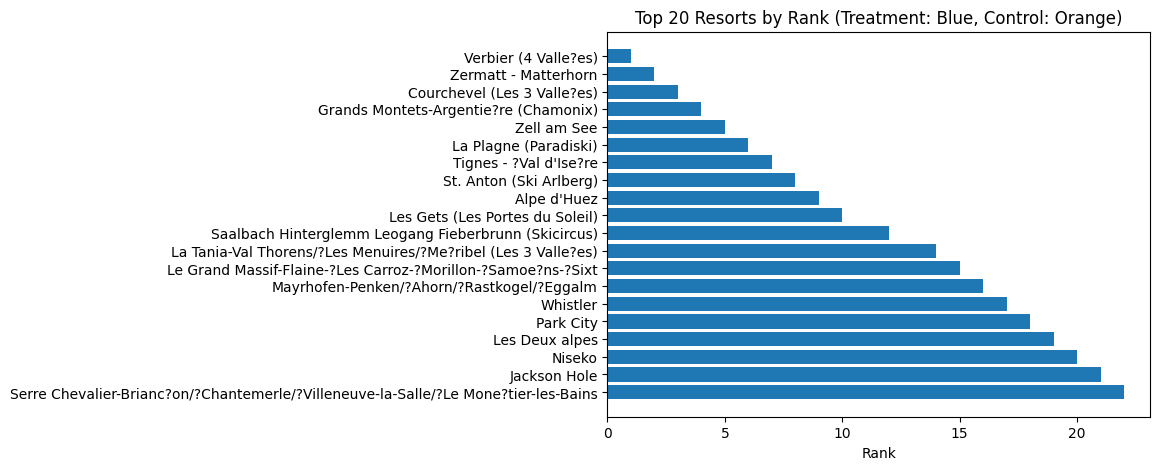

In [286]:
# Top ratings resorts
k = 20  # number of top resorts to show
T_COL = 'Snowparks_numeric'
target = 'Rank'

# Get top k resorts by price
top_df = merged.nsmallest(k, target).copy()
# top_df = merged.nlargest(k, target).copy()
top_df = top_df.sort_values(target, ascending=False)

# Assign colors: blue for treatment, orange for control
colors = ['#1f77b4' if t == 1 else '#ff7f0e' for t in top_df[T_COL]]

plt.figure(figsize=(7, 5))
plt.barh(top_df['Resort'], top_df[target], color=colors)
plt.xlabel('Rank')
plt.title(f'Top {k} Resorts by Rank (Treatment: Blue, Control: Orange)')
plt.show()

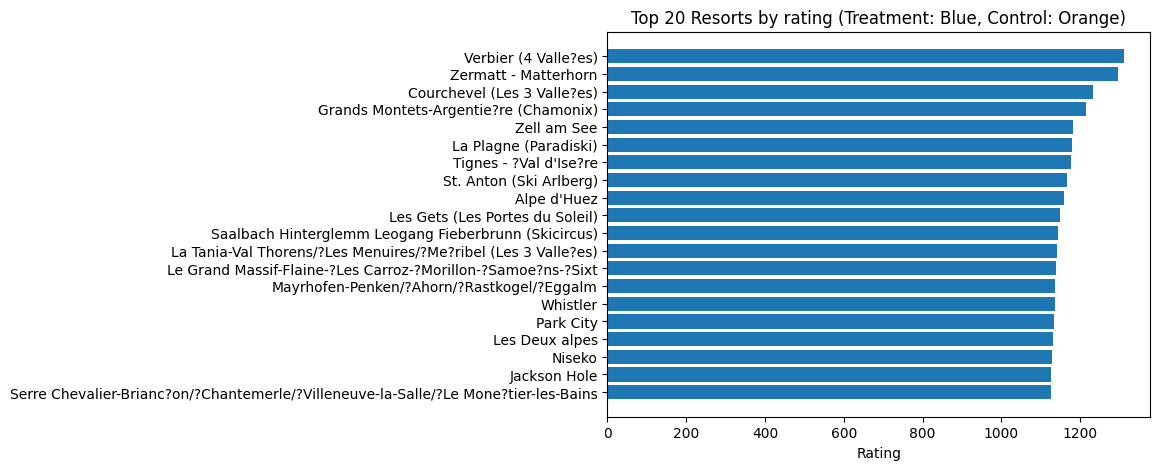

In [287]:
# Top ratings resorts
k = 20  # number of top resorts to show
T_COL = 'Snowparks_numeric'
target = 'Rating'

# Get top k resorts by price
# top_df = merged.nsmallest(k, target).copy()
top_df = merged.nlargest(k, target).copy()
top_df = top_df.sort_values(target, ascending=True)

# Assign colors: blue for treatment, orange for control
colors = ['#1f77b4' if t == 1 else '#ff7f0e' for t in top_df[T_COL]]

plt.figure(figsize=(7, 5))
plt.barh(top_df['Resort'], top_df[target], color=colors)
plt.xlabel('Rating')
plt.title(f'Top {k} Resorts by rating (Treatment: Blue, Control: Orange)')
plt.show()

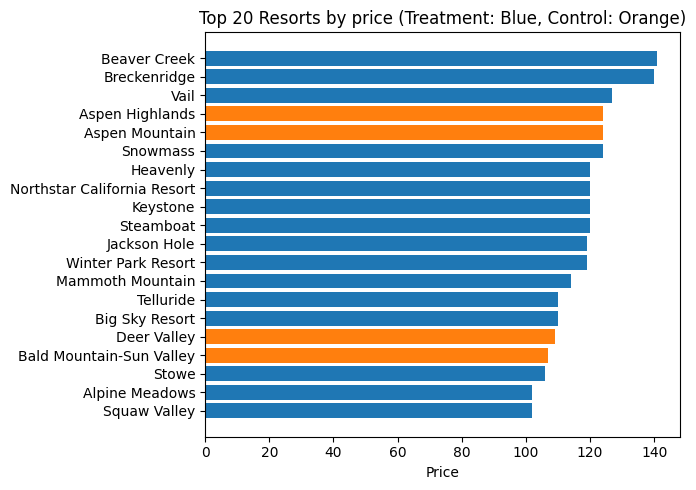

In [288]:
# Top prices resorts
k = 20  # number of top resorts to show
T_COL = 'Snowparks_numeric'
target = 'Price'

# Get top k resorts by price
# top_df = merged.nsmallest(k, target).copy()
top_df = merged.nlargest(k, target).copy()
top_df = top_df.sort_values(target, ascending=True)

# Assign colors: blue for treatment, orange for control
colors = ['#1f77b4' if t == 1 else '#ff7f0e' for t in top_df[T_COL]]

plt.figure(figsize=(7, 5))
plt.barh(top_df['Resort'], top_df[target], color=colors)
plt.xlabel('Price')
plt.title(f'Top {k} Resorts by price (Treatment: Blue, Control: Orange)')
plt.tight_layout()
plt.show()

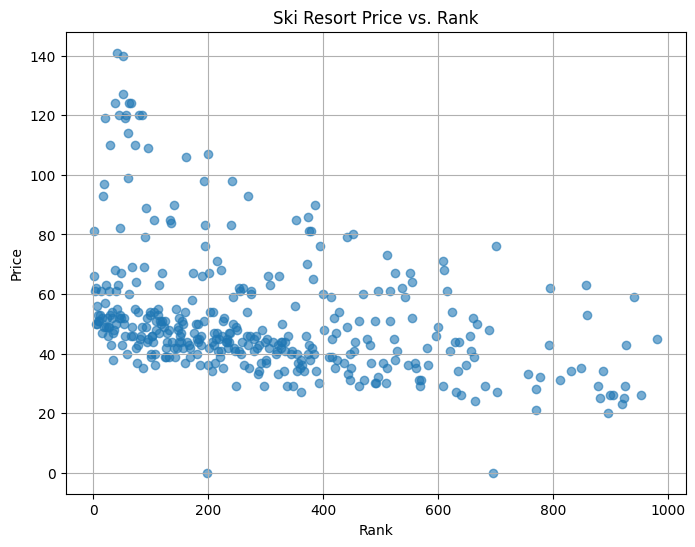

Correlation between Price and rank: -0.379


In [289]:
low_rank_merged = merged[merged['rank'] < 1000] # lower rank better the resort! 
# Plot Price vs. rank
plt.figure(figsize=(8, 6))
plt.scatter(low_rank_merged['rank'], low_rank_merged['Price'], alpha=0.6)
plt.xlabel('Rank')
plt.ylabel('Price')
plt.title('Ski Resort Price vs. Rank')
plt.grid(True)
plt.show()

# Print the correlation between Price and rank
correlation = low_rank_merged['Price'].corr(low_rank_merged['rank'])
print(f"Correlation between Price and rank: {correlation:.3f}")


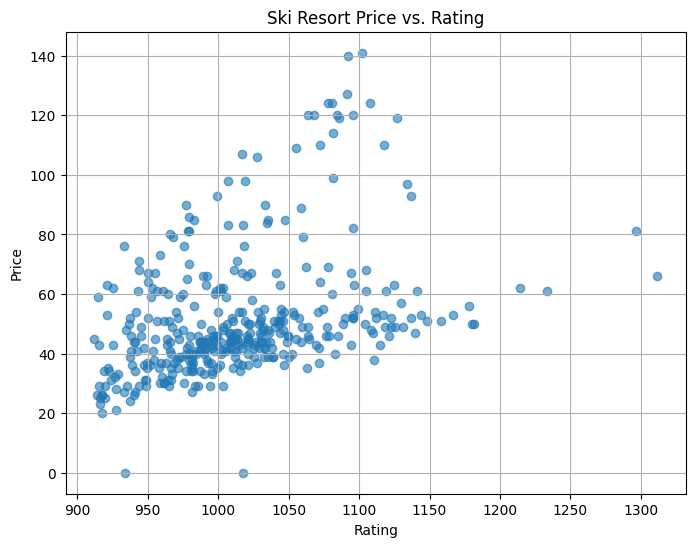

Correlation between Price and Rating: 0.389


In [325]:
low_rank_merged = merged[merged['rank'] < 1000] # lower rank better the resort! 
# Plot Price vs. rating
plt.figure(figsize=(8, 6))
plt.scatter(low_rank_merged['Rating'], low_rank_merged['Price'], alpha=0.6)
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('Ski Resort Price vs. Rating')
plt.grid(True)
plt.show()

# Print the correlation between Price and rank
correlation = low_rank_merged['Price'].corr(low_rank_merged['Rating'])
print(f"Correlation between Price and Rating: {correlation:.3f}")


In [291]:
# saved merged DF
name = "data/merged_ski_data.csv"
merged.to_csv(name, index=False)

In [292]:
print(merged['rank'].isna().sum())
part_df = merged.dropna(axis=0)  #ski_df #.dropna(axis=0)
print(f"no None merge={len(part_df['ID'])}")
part_df.head(10)

68
no None merge=431


,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,key,Rank,Other_name,Rating,rank
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,hemsedal,69.0,Hemsedal,1076.9,69.0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,geilosiden geilo,259.0,Geilo,1001.8,259.0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,golm,250.0,Golm,1003.6,250.0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,red rossland,275.0,Red Mountain Resort,998.0,275.0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,hafjell,219.0,Hafjell,1012.3,219.0
5,6,Voss,60.683706,6.407905,Norway,Europe,43,November - May,960,284,25,4,11,40,0,40,7,4,0,11,11900,Yes,Yes,No,No,0,0,1,1,0,0,7,voss,288.0,Voss Resort,995.7,288.0
8,9,Hochschwarzeck,47.628373,12.920528,Germany,Europe,22,December - April,1385,1030,4,0,0,4,0,0,3,1,0,4,2880,Yes,No,No,No,5,0,1,0,0,0,5,hochschwarzeck,1200.0,Hochschwarzeck,899.1,1200.0
9,10,Rossfeld - Berchtesgaden - Oberau,47.651306,13.058977,Germany,Europe,20,December - April,1554,1300,7,1,0,8,6,0,4,0,0,4,3229,Yes,Yes,Yes,No,5,0,1,1,1,0,5,rossfeld berchtesgaden oberau,1291.0,Rossfeld,893.4,1291.0
10,11,Fernie,49.504175,-115.062867,Canada,North America,67,December - April,2134,1052,42,58,42,142,5,11,3,7,0,10,14514,Yes,Yes,No,No,2,1,1,1,0,0,5,fernie,120.0,Fernie,1040.9,120.0
11,12,Sun Peaks,50.884468,-119.882329,Canada,North America,62,November - April,2082,1198,13,78,43,134,8,0,6,6,0,12,13895,Yes,Yes,Yes,No,2,1,1,1,1,0,6,sun peaks,253.0,Sun Peaks,1003.2,253.0


In [ ]:
# Rank ATE
print("=== DIAGNOSTIC INFORMATION ===")

# Check the actual values in Snowparks columns
def basic_ATE(df, outcome_col):
    with_sp_data = df[df[T_COL] == 1][outcome_col]
    without_sp_data = df[df[T_COL] == 0][outcome_col]

    print(f"\nNumber of resorts with snowparks (treatment=1): {len(with_sp_data)}")
    print(f"Number of resorts without snowparks (treatment=0): {len(without_sp_data)}")

    if len(with_sp_data) > 0 and len(without_sp_data) > 0: # if somehow one of the groups is emtpy
        with_sp = np.mean(with_sp_data)
        without_sp = np.mean(without_sp_data)
        ate = with_sp - without_sp

        print(f"\nMean {outcome_col} for resorts WITH snowparks: {with_sp:.2f}")
        print(f"Mean {outcome_col} for resorts WITHOUT snowparks: {without_sp:.2f}")
        print(f"Average Treatment Effect (ATE): {ate:.2f}")
        print(f"Percentage Change: {ate/without_sp * 100:.2f}%")
        
        # Interpretation
        if outcome_col.lower() == 'rank':
            if ate < 0:
                print("Interpretation: Having snowparks is associated with BETTER ranking (lower rank number)")
            else:
                print("Interpretation: Having snowparks is associated with WORSE ranking (higher rank number)")
        else:
            if ate > 0:
                print("Interpretation: Having snowparks is associated with BETTER outcomes (higher price or rating)")
            else:
                print("Interpretation: Having snowparks is associated with WORSE outcomes (lower price)")
    else:
        print("\nCannot calculate ATE - missing data in one or both treatment groups")
        if len(with_sp_data) == 0:
            print("No resorts with snowparks found in the dataset")
        if len(without_sp_data) == 0:
            print("No resorts without snowparks found in the dataset")

basic_ATE(part_df, 'rank')

=== DIAGNOSTIC INFORMATION ===

Number of resorts with snowparks (treatment=1): 337
Number of resorts without snowparks (treatment=0): 94

Mean rank for resorts WITH snowparks: 428.58
Mean rank for resorts WITHOUT snowparks: 705.02
Average Treatment Effect (ATE): -276.45
Percentage Change: -39.21%
Interpretation: Having snowparks is associated with BETTER ranking (lower rank number)


basic_ATE(part_df, "Rating")

In [294]:
basic_ATE(part_df, "Rating")


Number of resorts with snowparks (treatment=1): 337
Number of resorts without snowparks (treatment=0): 94

Mean Rating for resorts WITH snowparks: 1007.47
Mean Rating for resorts WITHOUT snowparks: 960.01
Average Treatment Effect (ATE): 47.46
Percentage Change: 4.94%
Interpretation: Having snowparks is associated with BETTER outcomes (higher price)


Price ATE

In [295]:
basic_ATE(part_df, 'Price')


Number of resorts with snowparks (treatment=1): 337
Number of resorts without snowparks (treatment=0): 94

Mean Price for resorts WITH snowparks: 52.54
Mean Price for resorts WITHOUT snowparks: 42.69
Average Treatment Effect (ATE): 9.85
Percentage Change: 23.07%
Interpretation: Having snowparks is associated with BETTER outcomes (higher price)


## EDA

In [296]:
target = 'Price'

if target == 'Rank' or target == 'Rating':
    df = merged_clean
else:
    df = merged
# df = merged_clean
numeric_cols = df.select_dtypes(include=[np.number]).columns
confounders = [col for col in numeric_cols if col not in ['Price', 'Rank', 'rank', 'ID', 'Snowparks_numeric', 'Resort_numeric','Rating']]
X = df[confounders]
treatment = 'Snowparks_numeric' #'Nightskiing'

# filtering only on condounders and target (possible ouctome)
y = df[target] 
X = df[confounders]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
confounders



['Latitude',
 'Longitude',
 'Highest point',
 'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'Country_numeric',
 'Continent_numeric',
 'Child friendly_numeric',
 'Nightskiing_numeric',
 'Summer skiing_numeric',
 'Season_numeric']

In [297]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
print("Linear Regression Train R^2:", lr_reg.score(X_train, y_train))
print("Linear Regression Test R^2:", lr_reg.score(X_test, y_test))


rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees
    max_depth=4,            # limit tree depth
    min_samples_leaf=10,    # require more samples per leaf
    random_state=42
)
rf.fit(X_train, y_train)
print("Random Forest Train R^2:", rf.score(X_train, y_train))
print("Random Forest Test R^2:", rf.score(X_test, y_test))


xgb = XGBRegressor(
    n_estimators=50,        # fewer boosting rounds
    max_depth=3,            # shallower trees
    min_child_weight=10,    # require more samples per leaf
    subsample=0.7,          # use a fraction of data for each tree
    colsample_bytree=0.7,   # use a fraction of features for each tree
    random_state=42
)
xgb.fit(X_train, y_train)
print("XGBoost Train R^2:", xgb.score(X_train, y_train))
print("XGBoost Test R^2:", xgb.score(X_test, y_test))


# Evaluation of all models
y_pred_lr = lr_reg.predict(X_test)
print("Linear Regression Metrics:")
print("  R^2:", r2_score(y_test, y_pred_lr))
print("  MSE:", mean_squared_error(y_test, y_pred_lr))
print("  MAE:", mean_absolute_error(y_test, y_pred_lr))

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Metrics:")
print("  R^2:", r2_score(y_test, y_pred_rf))
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  MAE:", mean_absolute_error(y_test, y_pred_rf))

y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Metrics:")
print("  R^2:", r2_score(y_test, y_pred_xgb))
print("  MSE:", mean_squared_error(y_test, y_pred_xgb))
print("  MAE:", mean_absolute_error(y_test, y_pred_xgb))



Linear Regression Train R^2: 0.5642259567128178
Linear Regression Test R^2: 0.5284504282510176
Random Forest Train R^2: 0.7756193172331148
Random Forest Test R^2: 0.7140671399479825
XGBoost Train R^2: 0.940575122833252
XGBoost Test R^2: 0.6962080597877502
Linear Regression Metrics:
  R^2: 0.5284504282510176
  MSE: 218.13293752143238
  MAE: 10.331145661783307

Random Forest Metrics:
  R^2: 0.7140671399479825
  MSE: 132.26896689931263
  MAE: 7.8922597756930095

XGBoost Metrics:
  R^2: 0.6962080597877502
  MSE: 140.53033447265625
  MAE: 6.344943046569824


Top features by importance (Random Forest):
Latitude: 0.536
Beginner slopes: 0.099
Total lifts: 0.095
Lift capacity: 0.068
Highest point: 0.037
ID: 0.027
Longitude: 0.025
Difficult slopes: 0.025
Chair lifts: 0.018
Gondola lifts: 0.018


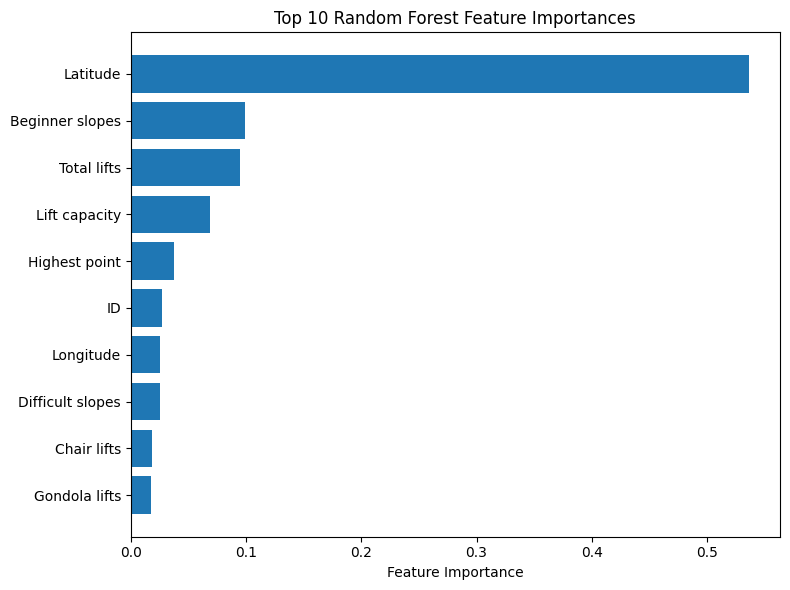

In [327]:
# Show the most important features for the Random Forest model (rf)
importances_target = rf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances_target.argsort()[::-1]
target_importances_features_names = feature_names[sorted_idx[:10]]
print("Top features by importance (Random Forest):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances_target[i]:.3f}")
plt.figure(figsize=(8, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], importances_target[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()  

Top features by importance (XGB Regressor):
Latitude: 0.176
Beginner slopes: 0.140
Total lifts: 0.099
Lift capacity: 0.065
Intermediate slopes: 0.065
Chair lifts: 0.063
Longitude: 0.061
Total slopes: 0.050
Difficult slopes: 0.048
ID: 0.045


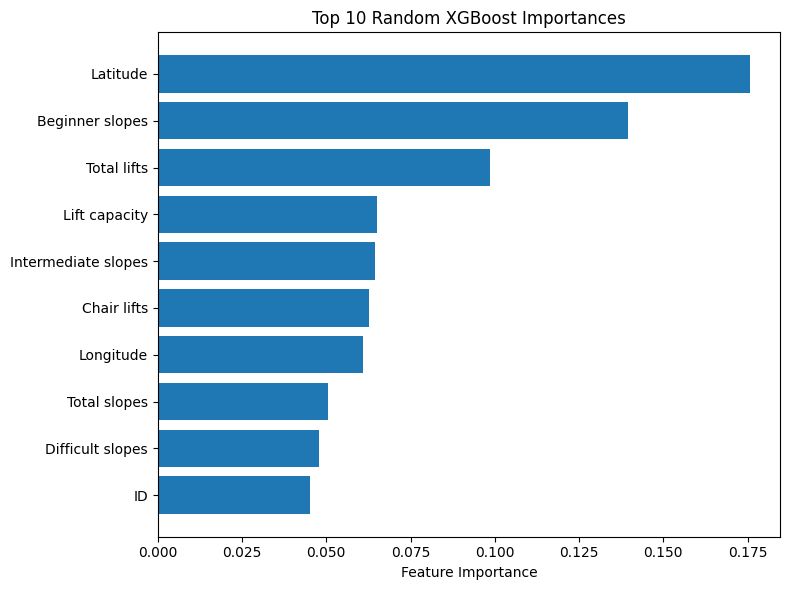

In [324]:
# Show the most important features for the Random Forest model (rf)
importances_target = xgb.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = importances_target.argsort()[::-1]
target_importances_features_names = feature_names[sorted_idx[:10]]
print("Top features by importance (XGB Regressor):")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances_target[i]:.3f}")
plt.figure(figsize=(8, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], importances_target[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Random XGBoost Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()  

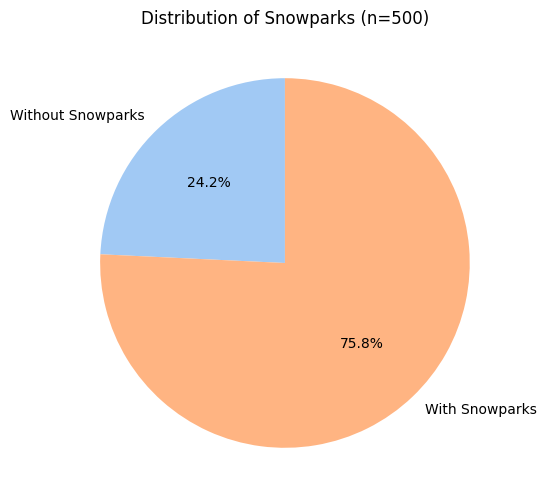

In [300]:
column  = "Snowparks_numeric" # "Snowparks"
# Count the occurrences for each value in the column
counts = ski_df[column].value_counts().sort_index()
labels_names = {1: 'With Snowparks', 0: 'Without Snowparks'}
labels = [labels_names[val] for val in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title(f"Distribution of Snowparks (n=500)")
plt.show()



In [301]:
ski_df.columns

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric', 'key',
       'Rank', 'Other_name', 'Rating'],
      dtype='object')

Grouping the countries to continents

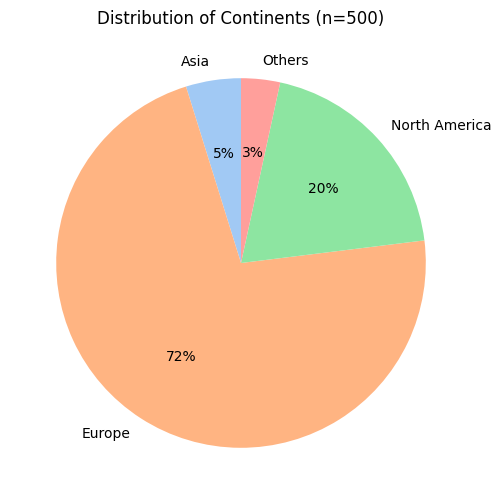

In [302]:
column  = "Continent" # "Snowparks"

# Count the occurrences for each value in the column
counts = ski_df[column].value_counts().sort_index()
# If a continent has less than 5% of the resorts, group it as 'Others'
threshold = 0.04 * counts.sum()
counts_grouped = counts.copy()
low_count_labels = counts[counts < threshold].index
counts_grouped['Others'] = counts_grouped[low_count_labels].sum()
counts_grouped = counts_grouped.drop(low_count_labels)
labels = [val for val in counts_grouped.index]
counts = counts_grouped
# labels_names = {1: 'With Snowparks', 0: 'Without Snowparks'}
labels = [val for val in counts.index]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.0f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title(f"Distribution of Continents (n=500)")
plt.show()

## Correlation

In [303]:
target = "Price"
mean_price_snowparks_0 = ski_df[ski_df["Snowparks_numeric"] == 0][target].mean()
mean_price_snowparks_1 = ski_df[ski_df["Snowparks_numeric"] == 1][target].mean()
print("Mean Price for Snowparks = 0:", round(mean_price_snowparks_0, 2))
print("Mean Price for Snowparks = 1:", round(mean_price_snowparks_1, 2))

Mean Price for Snowparks = 0: 40.39
Mean Price for Snowparks = 1: 51.39


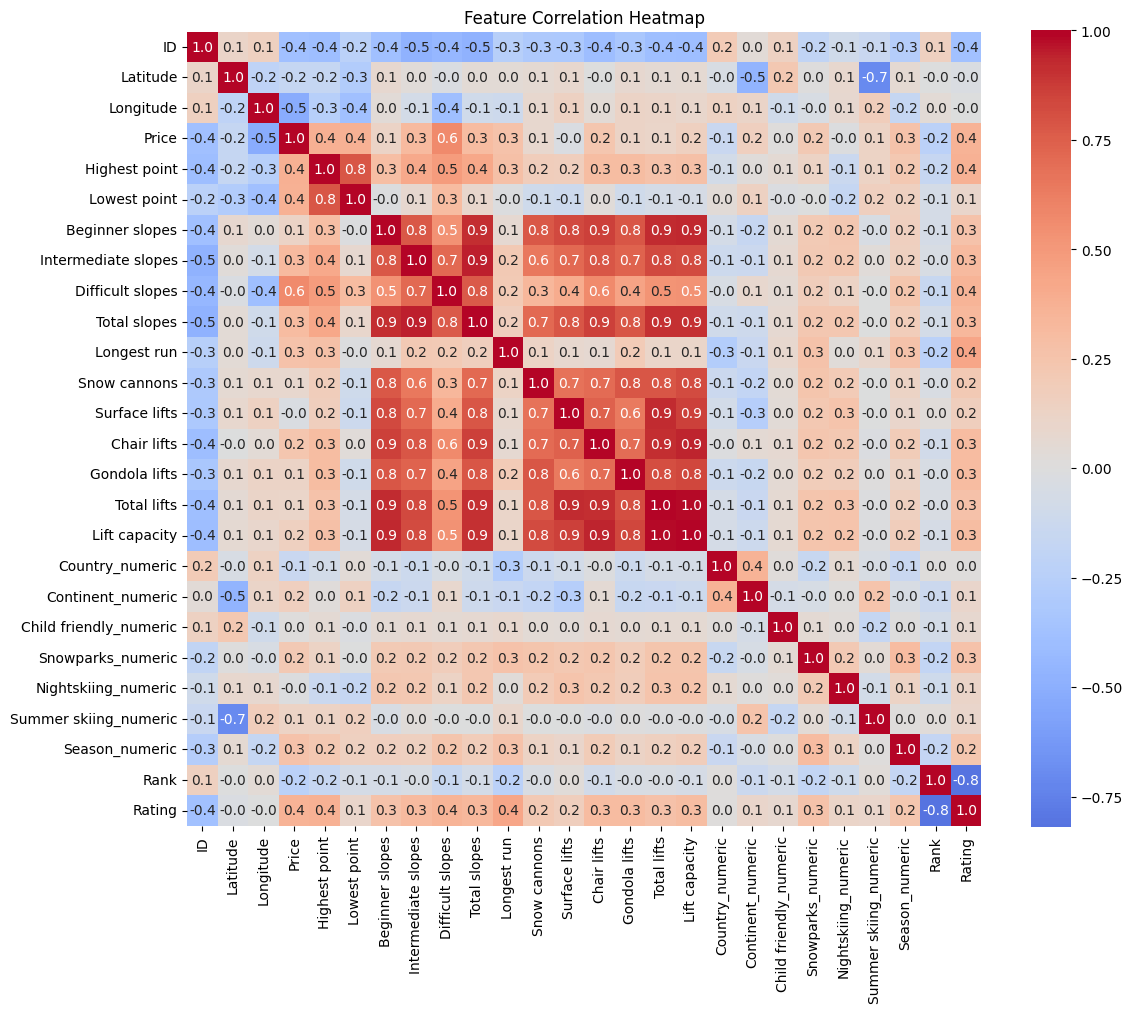

In [304]:
correlation_matrix = ski_df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f', square=True)

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In the end we have these datasets: 

- `merged` - contains nulls in ratings and rankings columns
- `merged_clean` - no nulls
- `ski_df` 

# Causal Assumptions for identification

## SUTVA

In [ ]:
ski_df

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,Longest run,Snow cannons,Surface lifts,Chair lifts,Gondola lifts,Total lifts,Lift capacity,Child friendly,Snowparks,Nightskiing,Summer skiing,Country_numeric,Continent_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,Season_numeric,key,Rank,Other_name,Rating,neighbor_treated_share
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,29,10,4,43,6,325,15,6,0,21,22921,Yes,Yes,Yes,No,0,0,1,1,1,0,7,hemsedal,69.0,Hemsedal,1076.9,1.000000
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,18,12,4,34,2,100,18,6,0,24,14225,Yes,Yes,Yes,No,0,0,1,1,1,0,6,geilosiden geilo,259.0,Geilo,1001.8,1.000000
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,13,12,1,26,9,123,4,4,3,11,16240,Yes,No,No,No,1,0,1,0,0,0,5,golm,250.0,Golm,1003.6,0.854545
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,20,50,50,120,7,0,2,5,1,8,9200,Yes,Yes,Yes,No,2,1,1,1,1,0,5,red rossland,275.0,Red Mountain Resort,998.0,0.000000
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,33,7,4,44,6,150,14,3,1,18,21060,Yes,Yes,Yes,No,0,0,1,1,1,0,6,hafjell,219.0,Hafjell,1012.3,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,Puigmal,42.395007,2.108883,France,Europe,0,Unknown,2700,1830,9,15,7,31,0,0,11,2,0,13,11865,Yes,No,No,No,8,0,1,0,0,0,0,puigmal,1086.0,Puigmal,905.7,0.833333
495,496,Kranzberg-Mittenwald,47.451359,11.228630,Germany,Europe,29,December,1350,980,6,7,2,15,2,8,9,1,0,10,5850,Yes,Yes,Yes,No,5,0,1,1,1,0,1,kranzberg mittenwald,568.0,Kranzberg,948.6,0.763636
496,497,Wetterstein lifts-Wettersteinbahnen- Ehrwald,47.406897,10.927998,Austria,Europe,43,December - March,1530,1000,15,5,3,23,3,33,6,4,0,10,5425,Yes,Yes,No,No,1,0,1,1,0,0,4,wetterstein lifts wettersteinbahnen ehrwald,481.0,Ehrwalder Wettersteinbahnen,963.5,0.773585
497,498,Stuhleck-Spital am Semmering,47.574195,15.789964,Austria,Europe,42,April,1774,777,18,6,0,24,0,240,7,2,0,9,14400,Yes,Yes,Yes,No,1,0,1,1,1,0,1,stuhleck spital am semmering,306.0,Stuhleck,991.5,0.750000


In [366]:
R = 6371  # Earth radius km
coords = np.radians(ski_df[['Latitude','Longitude']].to_numpy())
D = pairwise .haversine_distances(coords, coords) * R

# neighbors within 100km
adj = (D <= 100) & (D > 0) # D>0 exculdes the resort itself

neighbor_treated_cnt = adj.dot(ski_df['Snowparks_numeric'].to_numpy())
neighbor_cnt = adj.sum(axis=1)
ski_df['neighbor_treated_share'] = np.where(neighbor_cnt>0, neighbor_treated_cnt/neighbor_cnt, 0.0)

X = ski_df[['Snowparks_numeric','neighbor_treated_share']] 
X = sm.add_constant(X)
model = sm.OLS(ski_df['Price'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.74
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           1.56e-06
Time:                        13:05:03   Log-Likelihood:                -2230.1
No. Observations:                 499   AIC:                             4466.
Df Residuals:                     496   BIC:                             4479.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     43

C:\Users\Cyber_User\AppData\Local\Temp\ipykernel_18116\3356620933.py:10: RuntimeWarning: invalid value encountered in divide
  ski_df['neighbor_treated_share'] = np.where(neighbor_cnt>0, neighbor_treated_cnt/neighbor_cnt, 0.0)


## Consistency

In [337]:
def smd(x_treat, x_control):
    return (x_treat.mean() - x_control.mean()) / np.sqrt(0.5*(x_treat.var()+x_control.var()))

balance = {}
for c in X.columns:
    balance[c] = smd(X.loc[ski_df[T_COL]==1, c], X.loc[ski_df[T_COL]==0, c])

print("Standardized mean differences (before matching):")
for k,v in balance.items():
    print(f"{k}: {v:.3f}")


Standardized mean differences (before matching):
const: nan
Snowparks_numeric: inf
neighbor_treated_share: 0.219


C:\Users\Cyber_User\AppData\Local\Temp\ipykernel_18116\2232480984.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (x_treat.mean() - x_control.mean()) / np.sqrt(0.5*(x_treat.var()+x_control.var()))
C:\Users\Cyber_User\AppData\Local\Temp\ipykernel_18116\2232480984.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (x_treat.mean() - x_control.mean()) / np.sqrt(0.5*(x_treat.var()+x_control.var()))


## Overlap (Common support)

In [307]:
# Check min/max propensity in both groups
treated = psm_df.loc[psm_df[T_COL]==1, 'propensity']
control = psm_df.loc[psm_df[T_COL]==0, 'propensity']

print("Treated group propensity range:", (treated.min(), treated.max()))
print("Control group propensity range:", (control.min(), control.max()))

# Check common support region
overlap_min = max(treated.min(), control.min())
overlap_max = min(treated.max(), control.max())
print("Common support region:", (overlap_min, overlap_max))

# Flag units outside common support
outside = psm_df[(psm_df['propensity'] < overlap_min) | (psm_df['propensity'] > overlap_max)]
print(f"Units outside common support: {len(outside)}")


Treated group propensity range: (np.float64(0.29291358863471667), np.float64(0.999999999985933))
Control group propensity range: (np.float64(0.010610355202812798), np.float64(0.9815421588598162))
Common support region: (np.float64(0.29291358863471667), np.float64(0.9815421588598162))
Units outside common support: 96


## Ignorability

# Other

## Casual Inference methods

### Method 1: Propensity Score Matching (PSM)

We estimate the causal effect of Snowparks (treatment=1 if a resort has snowparks) on Price (lift ticket price) by:
- Estimating propensity scores P(T=1|X) with Logistic Regression using numeric confounders.
- Matching treated resorts to nearest control by propensity score (1-to-1, without replacement, caliper).
- Computing the Average Treatment effect on the Treated (ATT) on matched pairs.
- Visualizing propensity overlap and matched mean outcomes.


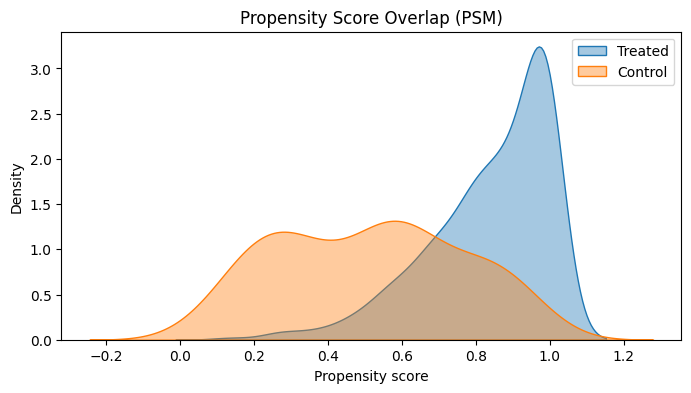

Top features by absolute coefficient (Propensity Model):
Snow cannons: 2.0803
Intermediate slopes: 0.8133
Surface lifts: 0.6228
Rating: 0.6015
Beginner slopes: 0.5568
Season_numeric: 0.5508
Lift capacity: 0.5154
Longest run: 0.4752
Nightskiing_numeric: 0.4011
Total lifts: 0.3874


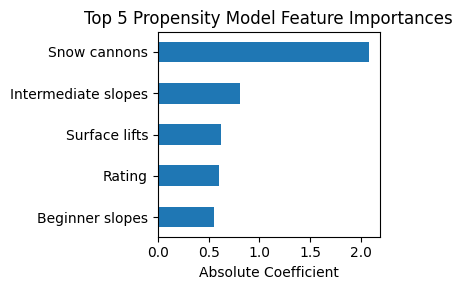

In [308]:
Y_COL = 'Price'

# Use numeric potential confounders (exclude the outcome, the treatment label, and external labels like Rank)
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {Y_COL, 'Rank', T_COL}  # EXCLUDE treatment to avoid leakage
X_cols = [c for c in numeric_cols if c not in ban_cols]

# Filter to rows where treatment and outcome are not NaN
psm_df = merged.dropna(subset=[T_COL, Y_COL]).copy()

# Ensure treatment is binary 0/1
if psm_df[T_COL].dtype != int and psm_df[T_COL].dtype != np.int64:
    # Factorize if not already numeric/binary
    vals = psm_df[T_COL].astype('category').cat.codes
    # Try to map to {0,1}
    # If more than 2 categories, we keep as is but warn in output
    psm_df[T_COL] = (vals > vals.median()).astype(int)

# Prepare X
X = psm_df[X_cols].fillna(0).copy()
# Protect against columns with zero variance
constant_cols = [c for c in X_cols if X[c].nunique(dropna=False) <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)

# Standardize X for logistic regression stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Propensity model
logit = LogisticRegression(max_iter=200, solver='lbfgs')
logit.fit(X_scaled, psm_df[T_COL])
ps = logit.predict_proba(X_scaled)[:, 1]
psm_df['propensity'] = ps

# Check overlap plot
plt.figure(figsize=(8,4))
sns.kdeplot(psm_df.loc[psm_df[T_COL]==1, 'propensity'], label='Treated', fill=True, alpha=0.4)
sns.kdeplot(psm_df.loc[psm_df[T_COL]==0, 'propensity'], label='Control', fill=True, alpha=0.4)
plt.title('Propensity Score Overlap (PSM)')
plt.xlabel('Propensity score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Show the most important features of the propensity model (Logistic Regression)
feature_importance_treatment = np.abs(logit.coef_[0])
sorted_idx = np.argsort(feature_importance_treatment)[::-1]
treatment_feature_names = X.columns[sorted_idx[:5]]
print("Top features by absolute coefficient (Propensity Model):")
for i in sorted_idx[:10]:
    print(f"{X.columns[i]}: {feature_importance_treatment[i]:.4f}")

# Plot feature importances with smaller bar width
plt.figure(figsize=(4, 3))
plt.barh([X.columns[i] for i in sorted_idx[:5]], feature_importance_treatment[sorted_idx[:5]], height=0.5)
plt.xlabel("Absolute Coefficient")
plt.title("Top 5 Propensity Model Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [309]:
# confounders

importances_both = list(set(target_importances_features_names) & set(treatment_feature_names))
importances_both


['Intermediate slopes']

In [310]:
# find the nearest neighbor for each treatment item and calculate 
# 1-to-1 nearest neighbor matching without replacement on propensity score
caliper = 0.3

treated_idx = psm_df.index[psm_df[T_COL]==1].to_numpy()
np.random.shuffle(treated_idx)
control_idx = psm_df.index[psm_df[T_COL]==0]

if len(treated_idx) == 0 or len(control_idx) == 0:
    print('PSM: Not enough treated or control units to match.')
else:
    att_list = []
    treated_prices = []
    control_prices = []
    number_of_runs = 100

    for i in range(number_of_runs):
        np.random.shuffle(treated_idx)
        treated_ps = psm_df.loc[treated_idx, 'propensity'].values.reshape(-1,1)
        control_ps = psm_df.loc[control_idx, 'propensity'].values.reshape(-1,1)

        # Compute all pairwise distances
        dists = pairwise_distances(treated_ps, control_ps)
        used_controls = set()
        matches = []
        for i, t_i in enumerate(treated_idx):
            # Sort control candidates by distance
            sorted_cands = np.argsort(dists[i])
            found = False
            for j in sorted_cands:
                c_j = control_idx[j]
                dist = dists[i, j]
                if dist <= caliper and c_j not in used_controls:
                    used_controls.add(c_j)
                    matches.append((t_i, c_j, dist))
                    found = True
                if found:
                    break

        # print(f'Matched pairs within caliper {caliper}: {len(matches)}')

        if len(matches) == 0:
            print('PSM: No pairs matched under the caliper constraint.')
        else:
            # Compute ATT using matched pairs
            diffs = []
            treatment_price = []
            control_price = []
            for t_i, c_j, _ in matches:
                y_t = psm_df.at[t_i, Y_COL]
                y_c = psm_df.at[c_j, Y_COL]
                diffs.append(y_t - y_c)
                treatment_price.append(y_t)
                control_price.append(y_c)
            att = float(np.mean(diffs))
            att_list.append(att)
            treated_prices.append(np.mean(treatment_price))
            control_prices.append(np.mean(control_price))

print(f'att mean={np.mean(att_list):.2f} std={np.std(att_list):.2f} over {number_of_runs} runs')
print("mean match treatment:", np.mean(treated_prices))
print("mean match control:", np.mean(control_prices))


att mean=4.01 std=1.44 over 100 runs
mean match treatment: 46.46889130262895
mean match control: 42.463539560056454


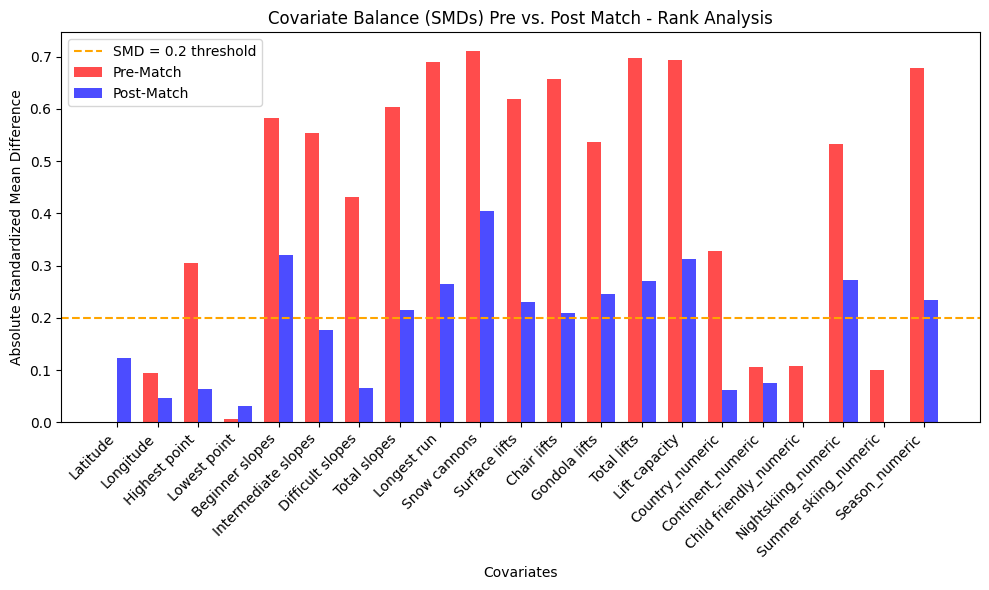

Number of covariates with |SMD| > 0.2 pre-match: 15
Number of covariates with |SMD| > 0.2 post-match: 11


In [311]:
# Covariate Balance Analysis for Rank PSM
def calculate_smd(x_treated, x_control):
    """Calculate standardized mean difference"""
    mean_t = np.mean(x_treated)
    mean_c = np.mean(x_control)
    var_t = np.var(x_treated, ddof=1)
    var_c = np.var(x_control, ddof=1)
    pooled_std = np.sqrt((var_t + var_c) / 2)
    if pooled_std == 0:
        return 0
    return (mean_t - mean_c) / pooled_std

# Calculate SMDs pre-match
smd_pre = []
covariate_names = []
for col in confounders:
    if col in psm_df.columns:
        treated_vals = psm_df[psm_df[T_COL]==1][col]
        control_vals = psm_df[psm_df[T_COL]==0][col]
        smd = calculate_smd(treated_vals, control_vals)
        smd_pre.append(abs(smd))
        covariate_names.append(col)

# Calculate SMDs post-match
smd_post = []
if len(matches) > 0:
    matched_treated_idx = [t for t, _, _ in matches]
    matched_control_idx = [c for _, c, _ in matches]
    
    for col in confounders:
        if col in psm_df.columns:
            treated_vals = psm_df.loc[matched_treated_idx, col]
            control_vals = psm_df.loc[matched_control_idx, col]
            smd = calculate_smd(treated_vals, control_vals)
            smd_post.append(abs(smd))

    # Create balance plot
    balance_df = pd.DataFrame({
        'Covariate': covariate_names,
        'Pre_Match': smd_pre,
        'Post_Match': smd_post
    })
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(covariate_names))
    width = 0.35
    
    threshold = 0.2
    plt.bar(x - width/2, smd_pre, width, label='Pre-Match', alpha=0.7, color='red')
    plt.bar(x + width/2, smd_post, width, label='Post-Match', alpha=0.7, color='blue')

    plt.axhline(y=threshold, color='orange', linestyle='--', label=f'SMD = {threshold} threshold')

    plt.xlabel('Covariates')
    plt.ylabel('Absolute Standardized Mean Difference')
    plt.title('Covariate Balance (SMDs) Pre vs. Post Match - Rank Analysis')
    plt.xticks(x, covariate_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Number of covariates with |SMD| > {threshold} pre-match: {sum(1 for smd in smd_pre if smd > threshold)}")
    print(f"Number of covariates with |SMD| > {threshold} post-match: {sum(1 for smd in smd_post if smd > threshold)}")

else:
    print("No matches found, cannot calculate post-match SMDs")

In [312]:
merged.columns

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Country_numeric',
       'Continent_numeric', 'Child friendly_numeric', 'Snowparks_numeric',
       'Nightskiing_numeric', 'Summer skiing_numeric', 'Season_numeric', 'key',
       'Rank', 'Other_name', 'Rating', 'rank'],
      dtype='object')

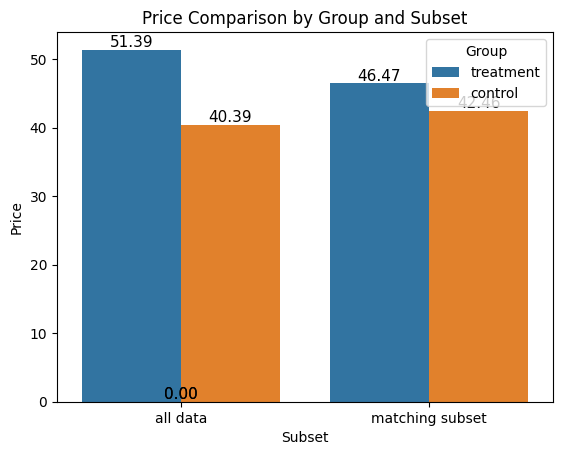

In [313]:
# before and after matching compression


compression = {'price': [merged[merged['Snowparks_numeric'] == 1]['Price'].mean(), np.mean(treated_prices) , merged[merged['Snowparks_numeric'] == 0]['Price'].mean(), np.mean(control_prices)], 
               'group': ['treatment', 'treatment', 'control', 'control'], 
               'Subset': ['all data', 'matching subset', 'all data', 'matching subset']}
compression = pd.DataFrame(compression)
sns.barplot(data=compression, x='Subset', y='price', hue='group', palette=['#1f77b4', '#ff7f0e'])
#add title and labels
plt.title('Price Comparison by Group and Subset')
plt.xlabel('Subset')
plt.ylabel('Price')
plt.legend(title='Group')
# Add bar counts on top of each bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black')
plt.show()


### Method 2: T-Learner (Two-Model Approach)

We fit two outcome models: one on treated units Y|T=1 and one on control units Y|T=0, using the same confounders X. The individual treatment effect (ITE) is the difference f1(X) - f0(X). We report the ATE and ATT and visualize the ITE distribution and CATE by key features.


T-Learner R^2 treated model (holdout): 0.461423060905672
T-Learner R^2 control model (holdout): 0.46237793775843306
T-Learner ATE: 4.66 | ATT: 4.94 | ATC: 3.78


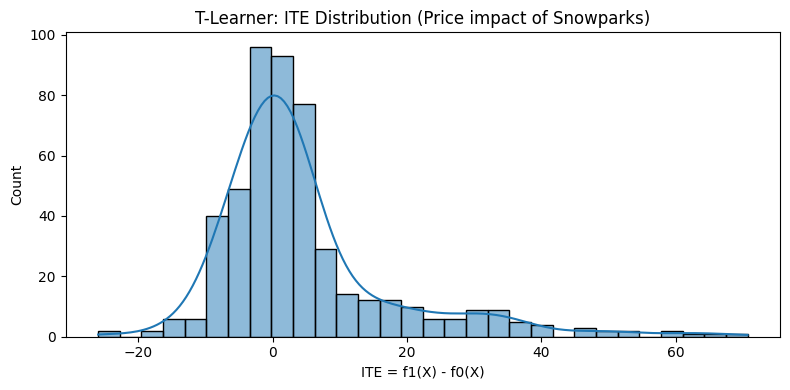

In [314]:
# Reuse columns and df from PSM setup if available

T_COL = 'Snowparks_numeric' if 'Snowparks_numeric' in merged.columns else 'Snowparks'
Y_COL = 'Price'
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {Y_COL, 'Rank', 'rank'}
X_cols = [c for c in numeric_cols if c not in ban_cols]

# Prepare data for T-learner
T_df = merged.dropna(subset=[T_COL, Y_COL]).copy()
X = T_df[X_cols].fillna(0)
Y = T_df[Y_COL]
T = T_df[T_COL]


# Split train/test to gauge model fit (optional)
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, Y, T, test_size=0.2, random_state=42, stratify=T)

# Models for treated and control
rf_t = RandomForestRegressor(n_estimators=150, max_depth=None, random_state=42)
rf_c = RandomForestRegressor(n_estimators=150, max_depth=None, random_state=42)

rf_t.fit(X_train[T_train==1], Y_train[T_train==1])
rf_c.fit(X_train[T_train==0], Y_train[T_train==0])

# Quick fit diagnostics
if (T_test==1).any() and (T_test==0).any():
    yhat_t = rf_t.predict(X_test[T_test==1])
    yhat_c = rf_c.predict(X_test[T_test==0])
    print('T-Learner R^2 treated model (holdout):', r2_score(Y_test[T_test==1], yhat_t))
    print('T-Learner R^2 control model (holdout):', r2_score(Y_test[T_test==0], yhat_c))

# ITE: f1(X) - f0(X)
f1_all = rf_t.predict(X)
f0_all = rf_c.predict(X)
ITE = f1_all - f0_all

# Aggregate effects
ATE = float(np.mean(ITE))
ATT = float(np.mean(ITE[T==1])) if (T==1).any() else np.nan
ATC = float(np.mean(ITE[T==0])) if (T==0).any() else np.nan
print(f'T-Learner ATE: {ATE:.2f} | ATT: {ATT:.2f} | ATC: {ATC:.2f}')

# Plot ITE distribution
plt.figure(figsize=(8,4))
sns.histplot(ITE, bins=30, kde=True)
plt.title('T-Learner: ITE Distribution (Price impact of Snowparks)')
plt.xlabel('ITE = f1(X) - f0(X)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



### S-Learner

S-learner R^2: 0.965
S-learner MSE: 16.41
S-learner MAE: 2.39
feature importances:
                Feature  Importance
2             Longitude    0.449824
23               Rating    0.169518
15        Lift capacity    0.061344
1              Latitude    0.057682
6   Intermediate slopes    0.039843
0                    ID    0.036236
13        Gondola lifts    0.028040
3         Highest point    0.024999
12          Chair lifts    0.017884
14          Total lifts    0.014949
7      Difficult slopes    0.014505
4          Lowest point    0.014410
5       Beginner slopes    0.012477
16      Country_numeric    0.010653
8          Total slopes    0.008528


S-learner ATE: -0.01
The mean predicted price for the control group is: 48.74
The mean predicted price for the treatment group is: 48.73


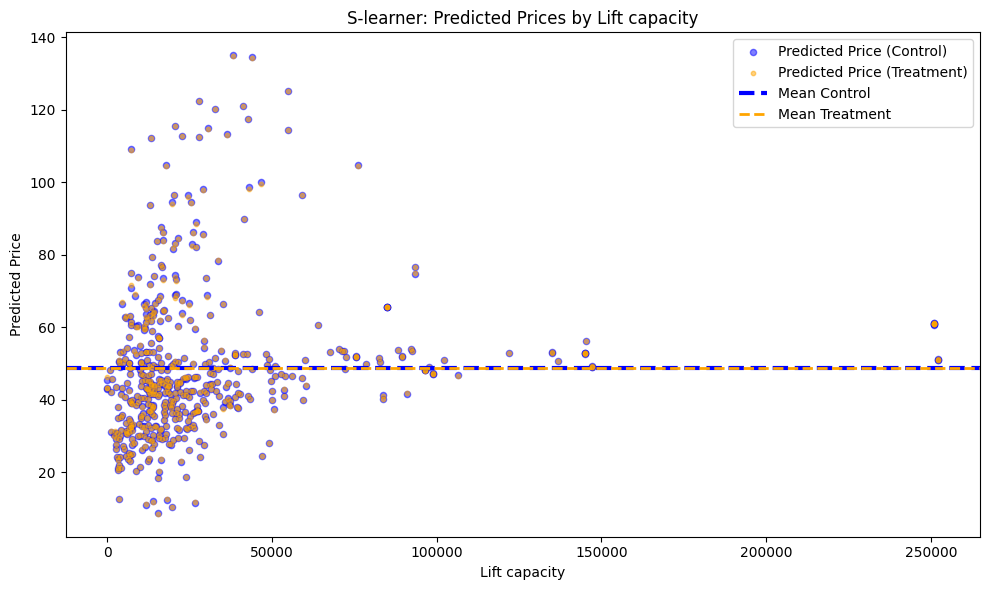

In [315]:
# S-learner setup
T_COL = 'Snowparks_numeric' if 'Snowparks_numeric' in merged.columns else 'Snowparks'
Y_COL = 'Price'
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {Y_COL, 'Rank', 'rank'}
X_cols = [c for c in numeric_cols if c not in ban_cols]

# Prepare data
s_df = merged.dropna(subset=[T_COL, Y_COL, 'Lift capacity']).copy()
X = s_df[X_cols].fillna(0)
T = s_df[T_COL].values.reshape(-1, 1)
Y = s_df[Y_COL].values
lift_capacity = s_df['Lift capacity'].values

# Add treatment as a feature
X_s = X.copy()
X_s['T'] = T

# Fit S-learner model
rf_s = RandomForestRegressor(n_estimators=150, random_state=42)
rf_s.fit(X_s, Y)
# Evaluate S-learner model performance

y_pred = rf_s.predict(X_s)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)

print(f"S-learner R^2: {r2:.3f}")
print(f"S-learner MSE: {mse:.2f}")
print(f"S-learner MAE: {mae:.2f}")
#add feature importances
importances = rf_s.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_s.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(f"feature importances:\n{feature_importance_df[:15]}\n\n")
# Predict potential outcomes for all units under T=1 and T=0
X_treated = X.copy()
X_treated['T'] = 1
X_control = X.copy()
X_control['T'] = 0

y_pred_treated = rf_s.predict(X_treated)
y_pred_control = rf_s.predict(X_control)

# Individual Treatment Effect (ITE) and ATE
ITE = y_pred_treated - y_pred_control
ATE = float(np.mean(ITE))
print(f"S-learner ATE: {ATE:.2f}")
print(f"The mean predicted price for the control group is: {np.mean(y_pred_control):.2f}")
print(f"The mean predicted price for the treatment group is: {np.mean(y_pred_treated):.2f}")

# Plot predicted prices by Lift capacity
plt.figure(figsize=(10, 6))
plt.scatter(lift_capacity, y_pred_control, color='blue', alpha=0.5, label='Predicted Price (Control)', s=20)
plt.scatter(lift_capacity, y_pred_treated, color='orange', alpha=0.5, label='Predicted Price (Treatment)', s=10)
plt.axhline(np.mean(y_pred_control), color='blue', linestyle='--', linewidth=3, label='Mean Control')
plt.axhline(np.mean(y_pred_treated), color='orange', linestyle='--', linewidth=2, label='Mean Treatment')
plt.xlabel('Lift capacity')
plt.ylabel('Predicted Price')
plt.title('S-learner: Predicted Prices by Lift capacity')
plt.legend()
plt.tight_layout()
plt.show()



### Method 3: Doubly Robust Estimation (AIPW)

We estimate the Average Treatment Effect (ATE) of Snowparks on Price using an Augmented Inverse Probability Weighting (AIPW) estimator:
- Step 1: Fit a propensity model P(T=1|X).
- Step 2: Fit two outcome models m1(X)=E[Y|T=1,X], m0(X)=E[Y|T=0,X].
- Step 3: Combine both with the AIPW formula, which is consistent if either the propensity model or the outcome models are correctly specified.
- We use cross-fitting to reduce overfitting bias, then report ATE and a 95% CI, and plot the influence function distribution.


AIPW ATE: -24.93 (95% CI: -82.35, 32.48)


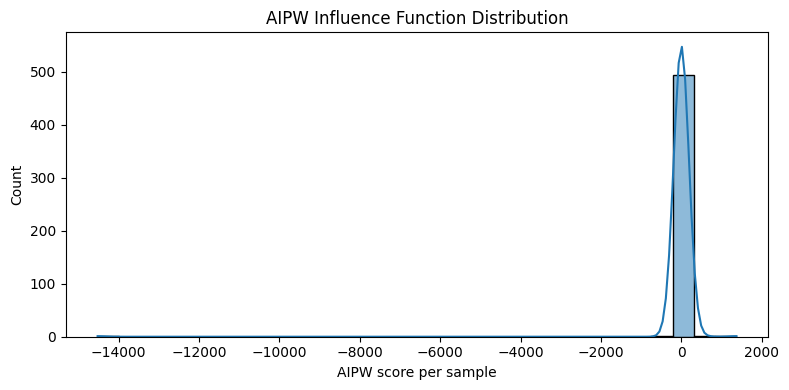

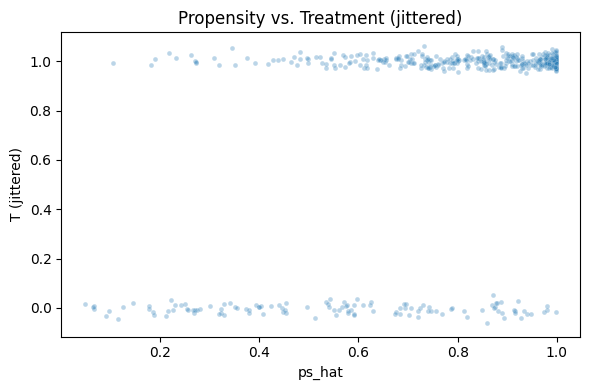

In [316]:
# Columns and data
T_COL = 'Snowparks_numeric' if 'Snowparks_numeric' in merged.columns else 'Snowparks'
Y_COL = 'Price'

numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {Y_COL, 'Rank', T_COL}
X_cols = [c for c in numeric_cols if c not in ban_cols]

# Prepare data
cf_df = merged.dropna(subset=[T_COL, Y_COL]).copy()
X = cf_df[X_cols].fillna(0)
Y = cf_df[Y_COL].values
T = cf_df[T_COL].values

# Ensure binary treatment
if len(np.unique(T)) > 2:
    T = (T.astype(float) > np.median(T.astype(float))).astype(int)

# Cross-fitting setup
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Storage
ps_hat = np.zeros(len(cf_df))
mu1_hat = np.zeros(len(cf_df))
mu0_hat = np.zeros(len(cf_df))

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    T_tr, T_te = T[train_idx], T[test_idx]
    Y_tr, Y_te = Y[train_idx], Y[test_idx]

    # Standardize for propensity only
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    # Propensity model
    logit = LogisticRegression(max_iter=200, solver='lbfgs')
    logit.fit(X_tr_scaled, T_tr)
    ps_hat[test_idx] = np.clip(logit.predict_proba(X_te_scaled)[:,1], 1e-3, 1-1e-3)

    # Outcome models
    rf1 = RandomForestRegressor(n_estimators=200, random_state=42)
    rf0 = RandomForestRegressor(n_estimators=200, random_state=42)

    rf1.fit(X_tr[T_tr==1], Y_tr[T_tr==1])
    rf0.fit(X_tr[T_tr==0], Y_tr[T_tr==0])

    mu1_hat[test_idx] = rf1.predict(X_te)
    mu0_hat[test_idx] = rf0.predict(X_te)

# AIPW influence function and ATE
ipw_term = T * (Y - mu1_hat) / ps_hat - (1 - T) * (Y - mu0_hat) / (1 - ps_hat)
aipw_scores = mu1_hat - mu0_hat + ipw_term
ATE = float(aipw_scores.mean())
SE = float(aipw_scores.std(ddof=1) / np.sqrt(len(aipw_scores)))
CI_low = ATE - 1.96 * SE
CI_high = ATE + 1.96 * SE

print(f'AIPW ATE: {ATE:.2f} (95% CI: {CI_low:.2f}, {CI_high:.2f})')

# Plot influence function distribution
plt.figure(figsize=(8,4))
sns.histplot(aipw_scores, bins=30, kde=True)
plt.title('AIPW Influence Function Distribution')
plt.xlabel('AIPW score per sample')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Optional: calibration check for propensity
plt.figure(figsize=(6,4))
sns.scatterplot(x=ps_hat, y=T + np.random.normal(0, 0.02, size=len(T)), alpha=0.3, s=12)
plt.title('Propensity vs. Treatment (jittered)')
plt.xlabel('ps_hat')
plt.ylabel('T (jittered)')
plt.tight_layout()
plt.show()


## Target = Rank

### Causal Inference on Rank Target

We now estimate the effect of Snowparks (treatment) on resort rank using three methods:
- S-Learner (single model with treatment as a feature)
- T-Learner (separate models for treated and control)
- Propensity Score Matching (PSM)

Each method will report ATE and show relevant plots.

S-Learner Rank ATE: 0.04 | ATT: 0.04 | ATC: 0.03


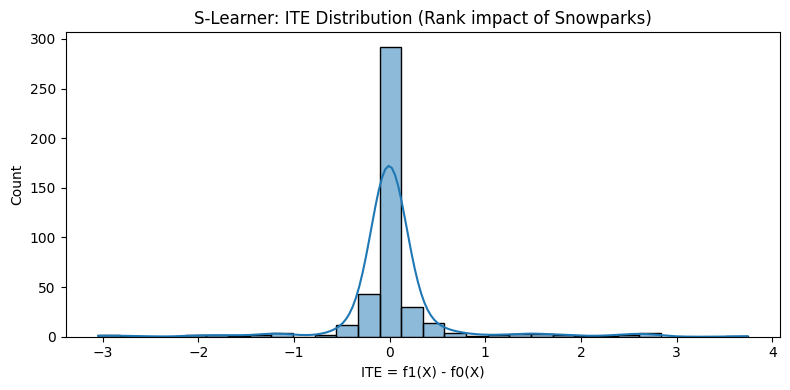

In [317]:
# S-Learner for Rank
T_COL = 'Snowparks_numeric' if 'Snowparks_numeric' in merged.columns else 'Snowparks'
Y_COL = 'rank'
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {'Price', 'Rank', 'rank'}
X_cols = [c for c in numeric_cols if c not in ban_cols]

rank_df = merged.dropna(subset=[T_COL, Y_COL]).copy()
X = rank_df[X_cols].fillna(0)
T = rank_df[T_COL]
Y = rank_df[Y_COL]

# S-Learner: fit one model with treatment as a feature
X_s = X.copy()
X_s['T'] = T
rf_s = RandomForestRegressor(n_estimators=150, random_state=42)
rf_s.fit(X_s, Y)

# Predict ITE for each unit
X1 = X.copy(); X1['T'] = 1
X0 = X.copy(); X0['T'] = 0
f1_s = rf_s.predict(X1)
f0_s = rf_s.predict(X0)
ITE_s = f1_s - f0_s
ATE_s = float(np.mean(ITE_s))
ATT_s = float(np.mean(ITE_s[T==1])) if (T==1).any() else np.nan
ATC_s = float(np.mean(ITE_s[T==0])) if (T==0).any() else np.nan
print(f'S-Learner Rank ATE: {ATE_s:.2f} | ATT: {ATT_s:.2f} | ATC: {ATC_s:.2f}')

plt.figure(figsize=(8,4))
sns.histplot(ITE_s, bins=30, kde=True)
plt.title('S-Learner: ITE Distribution (Rank impact of Snowparks)')
plt.xlabel('ITE = f1(X) - f0(X)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

T-Learner Rank ATE: -7.86 | ATT: -7.86 | ATC: -7.85


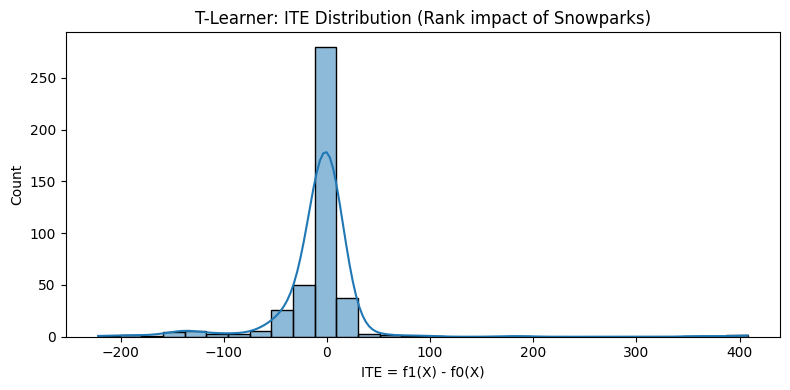

In [318]:
# T-Learner for Rank
# Use same X, T, Y as above
rf_t = RandomForestRegressor(n_estimators=150, random_state=42)
rf_c = RandomForestRegressor(n_estimators=150, random_state=42)
rf_t.fit(X[T==1], Y[T==1])
rf_c.fit(X[T==0], Y[T==0])
f1_t = rf_t.predict(X)
f0_t = rf_c.predict(X)
ITE_t = f1_t - f0_t
ATE_t = float(np.mean(ITE_t))
ATT_t = float(np.mean(ITE_t[T==1])) if (T==1).any() else np.nan
ATC_t = float(np.mean(ITE_t[T==0])) if (T==0).any() else np.nan
print(f'T-Learner Rank ATE: {ATE_t:.2f} | ATT: {ATT_t:.2f} | ATC: {ATC_t:.2f}')

plt.figure(figsize=(8,4))
sns.histplot(ITE_t, bins=30, kde=True)
plt.title('T-Learner: ITE Distribution (Rank impact of Snowparks)')
plt.xlabel('ITE = f1(X) - f0(X)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

###  Propensity Score Matching (PSM)

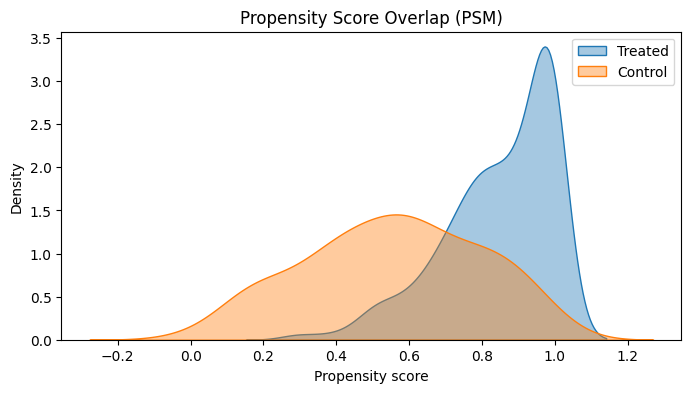

Top features by absolute coefficient (Propensity Model):
Snow cannons: 2.0243
Intermediate slopes: 0.9833
Lift capacity: 0.7173
Beginner slopes: 0.6569
Season_numeric: 0.6253
Chair lifts: 0.5435
Surface lifts: 0.4064
Longest run: 0.4035
Total lifts: 0.3898
Lowest point: 0.3890


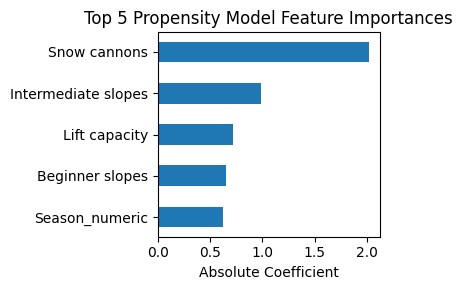

In [319]:
# === CONFIG ===
# Treatment and outcome
T_COL = 'Snowparks_numeric' if 'Snowparks_numeric' in merged.columns else 'Snowparks'
Y_COL = 'Rank'

# Use numeric potential confounders (exclude the outcome, the treatment label, and external labels like Rank)
numeric_cols = merged_clean.select_dtypes(include=[np.number]).columns.tolist()
ban_cols = {Y_COL, 'Rank', T_COL}  # EXCLUDE treatment to avoid leakage
X_cols = confounders

# Filter to rows where treatment and outcome are not NaN
psm_df = merged_clean.dropna(subset=[T_COL, Y_COL]).copy()

# Ensure treatment is binary 0/1
if psm_df[T_COL].dtype != int and psm_df[T_COL].dtype != np.int64:
    # Factorize if not already numeric/binary
    vals = psm_df[T_COL].astype('category').cat.codes
    # Try to map to {0,1}
    # If more than 2 categories, we keep as is but warn in output
    psm_df[T_COL] = (vals > vals.median()).astype(int)

# Prepare X
X = psm_df[X_cols].fillna(0).copy()
# Protect against columns with zero variance
constant_cols = [c for c in X_cols if X[c].nunique(dropna=False) <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)

# Standardize X for logistic regression stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Propensity model
logit = LogisticRegression(max_iter=200, solver='lbfgs')
logit.fit(X_scaled, psm_df[T_COL])
ps = logit.predict_proba(X_scaled)[:, 1]
psm_df['propensity'] = ps

# Check overlap plot
plt.figure(figsize=(8,4))
sns.kdeplot(psm_df.loc[psm_df[T_COL]==1, 'propensity'], label='Treated', fill=True, alpha=0.4)
sns.kdeplot(psm_df.loc[psm_df[T_COL]==0, 'propensity'], label='Control', fill=True, alpha=0.4)
plt.title('Propensity Score Overlap (PSM)')
plt.xlabel('Propensity score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Show the most important features of the propensity model (Logistic Regression)
feature_importance_treatment = np.abs(logit.coef_[0])
sorted_idx = np.argsort(feature_importance_treatment)[::-1]
treatment_feature_names = X.columns[sorted_idx[:10]]
print("Top features by absolute coefficient (Propensity Model):")
for i in sorted_idx[:10]:
    print(f"{X.columns[i]}: {feature_importance_treatment[i]:.4f}")

# Plot feature importances
plt.figure(figsize=(4, 3))
plt.barh([X.columns[i] for i in sorted_idx[:5]], feature_importance_treatment[sorted_idx[:5]], height=0.5)
plt.xlabel("Absolute Coefficient")
plt.title("Top 5 Propensity Model Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [320]:
# find the nearest neighbor for each treatment item and calculate 
# 1-to-1 nearest neighbor matching without replacement on propensity score
# === CONFIG ===
caliper = 0.1

# For each treated, find the closest available control within caliper
from sklearn.metrics import pairwise_distances

treated_idx = psm_df.index[psm_df[T_COL]==1].to_numpy()
np.random.shuffle(treated_idx)
control_idx = psm_df.index[psm_df[T_COL]==0]

if len(treated_idx) == 0 or len(control_idx) == 0:
    print('PSM: Not enough treated or control units to match.')
else:
    att_list = []
    treated_prices = []
    control_prices = []
    number_of_runs = 100

    for i in range(number_of_runs):
        np.random.shuffle(treated_idx)
        treated_ps = psm_df.loc[treated_idx, 'propensity'].values.reshape(-1,1)
        control_ps = psm_df.loc[control_idx, 'propensity'].values.reshape(-1,1)

        # Compute all pairwise distances
        dists = pairwise_distances(treated_ps, control_ps)
        used_controls = set()
        matches = []
        for i, t_i in enumerate(treated_idx):
            # Sort control candidates by distance
            sorted_cands = np.argsort(dists[i])
            found = False
            for j in sorted_cands:
                c_j = control_idx[j]
                dist = dists[i, j]
                if dist <= caliper and c_j not in used_controls:
                    used_controls.add(c_j)
                    matches.append((t_i, c_j, dist))
                    found = True
                if found:
                    break

        # print(f'Matched pairs within caliper {caliper}: {len(matches)}')

        if len(matches) == 0:
            print('PSM: No pairs matched under the caliper constraint.')
        else:
            # Compute ATT using matched pairs
            diffs = []
            treatment_price = []
            control_price = []
            for t_i, c_j, _ in matches:
                y_t = psm_df.at[t_i, Y_COL]
                y_c = psm_df.at[c_j, Y_COL]
                diffs.append(y_t - y_c)
                treatment_price.append(y_t)
                control_price.append(y_c)
            att = float(np.mean(diffs))
            att_list.append(att)
            treated_prices.append(np.mean(treatment_price))
            control_prices.append(np.mean(control_price))
att = np.mean(att_list) if att_list else np.nan
print(f'att mean={att:.2f} std={np.std(att_list):.2f} over {number_of_runs} runs')
print("mean match treatment:", np.mean(treated_prices))
print("mean match control:", np.mean(control_prices))

print(len(treated_prices), len(control_prices))

if not att_list:
    print('PSM: No ATT estimates available.')


att mean=-89.64 std=45.65 over 100 runs
mean match treatment: 526.0721618617646
mean match control: 615.7133335944911
100 100


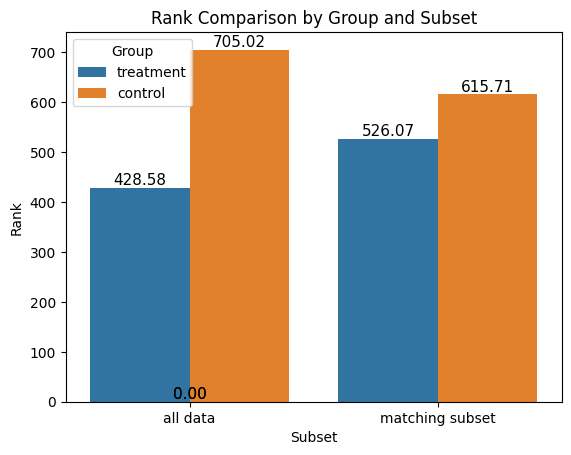

In [321]:
# before and after matching compression


compression = {'rank': [merged[merged['Snowparks_numeric'] == 1]['Rank'].mean(), np.mean(treated_prices) , merged[merged['Snowparks_numeric'] == 0]['Rank'].mean(), np.mean(control_prices)], 
               'group': ['treatment', 'treatment', 'control', 'control'], 
               'Subset': ['all data', 'matching subset', 'all data', 'matching subset']}
compression = pd.DataFrame(compression)
sns.barplot(data=compression, x='Subset', y='rank', hue='group', palette=['#1f77b4', '#ff7f0e'])
#add title and labels
plt.title('Rank Comparison by Group and Subset')
plt.xlabel('Subset')
plt.ylabel('Rank')
plt.legend(title='Group')
# Add bar counts on top of each bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black')
plt.show()

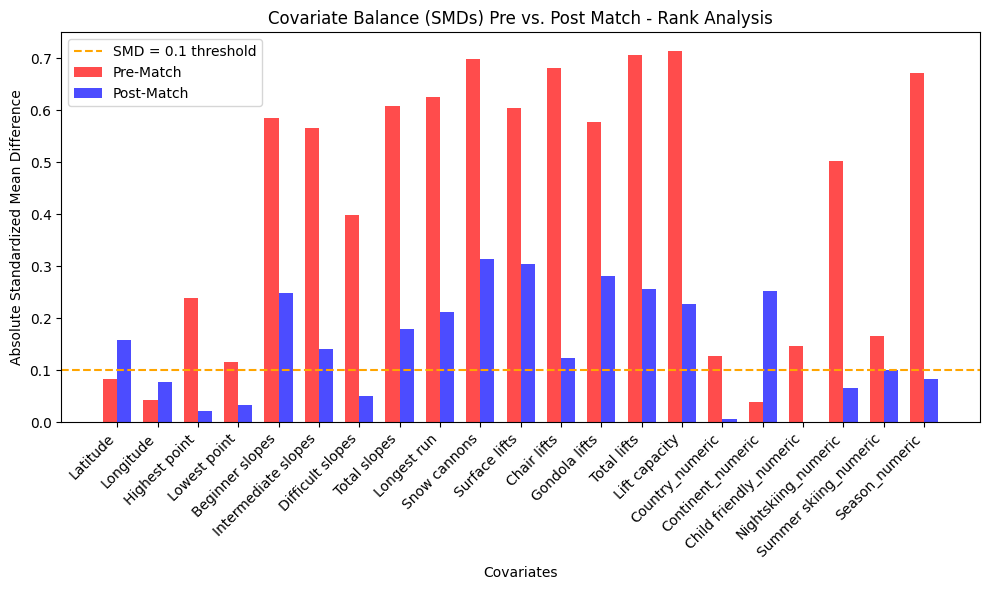

Number of covariates with |SMD| > 0.1 pre-match: 18
Number of covariates with |SMD| > 0.1 post-match: 12


In [322]:
# Covariate Balance Analysis for Rank PSM
def calculate_smd(x_treated, x_control):
    """Calculate standardized mean difference"""
    mean_t = np.mean(x_treated)
    mean_c = np.mean(x_control)
    var_t = np.var(x_treated, ddof=1)
    var_c = np.var(x_control, ddof=1)
    pooled_std = np.sqrt((var_t + var_c) / 2)
    if pooled_std == 0:
        return 0
    return (mean_t - mean_c) / pooled_std

# Calculate SMDs pre-match
smd_pre = []
covariate_names = []
for col in confounders:
    if col in psm_df.columns:
        treated_vals = psm_df[psm_df[T_COL]==1][col]
        control_vals = psm_df[psm_df[T_COL]==0][col]
        smd = calculate_smd(treated_vals, control_vals)
        smd_pre.append(abs(smd))
        covariate_names.append(col)

# Calculate SMDs post-match
smd_post = []
if len(matches) > 0:
    matched_treated_idx = [t for t, _, _ in matches]
    matched_control_idx = [c for _, c, _ in matches]
    
    for col in confounders:
        if col in psm_df.columns:
            treated_vals = psm_df.loc[matched_treated_idx, col]
            control_vals = psm_df.loc[matched_control_idx, col]
            smd = calculate_smd(treated_vals, control_vals)
            smd_post.append(abs(smd))

    # Create balance plot
    balance_df = pd.DataFrame({
        'Covariate': covariate_names,
        'Pre_Match': smd_pre,
        'Post_Match': smd_post
    })
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(covariate_names))
    width = 0.35
    
    plt.bar(x - width/2, smd_pre, width, label='Pre-Match', alpha=0.7, color='red')
    plt.bar(x + width/2, smd_post, width, label='Post-Match', alpha=0.7, color='blue')
    
    plt.axhline(y=0.1, color='orange', linestyle='--', label='SMD = 0.1 threshold')
    
    plt.xlabel('Covariates')
    plt.ylabel('Absolute Standardized Mean Difference')
    plt.title('Covariate Balance (SMDs) Pre vs. Post Match - Rank Analysis')
    plt.xticks(x, covariate_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Number of covariates with |SMD| > 0.1 pre-match: {sum(1 for smd in smd_pre if smd > 0.1)}")
    print(f"Number of covariates with |SMD| > 0.1 post-match: {sum(1 for smd in smd_post if smd > 0.1)}")

else:
    print("No matches found, cannot calculate post-match SMDs")

## Robustness

For SUTVA:
If competition might matter, restrict your dataset to geographically distant resorts and check if results change (a robustness check).